# DQC for AFL Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, geom_point, aes, facet_wrap, geom_area


## Match Data

### Data Quality Checking

In [3]:
#Load in the match data
df_matches = pd.read_csv('../data/MatchData_v2.csv',index_col=0)
#Limit to pre 2024
df_matches = df_matches[df_matches['Season']<2024]

In [4]:
#Convert weather data into numerical
weather_vars = ['Rain (mm)','Max Temp (C)','Min Temp (C)','Max Temp (C)','Min Temp (C)',
                'Max Humid (%)','Min Humid (%)','Wind Speed (m/s)','Solar Rad (MJ/sq m)']

for var in weather_vars:
    df_matches[var] = pd.to_numeric(df_matches[var],errors='coerce') 

In [5]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4894 entries, 0 to 5100
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Team                 4894 non-null   object 
 1   Opponent             4894 non-null   object 
 2   PointsF              4894 non-null   float64
 3   PointsA              4894 non-null   float64
 4   Venue                4894 non-null   object 
 5   Season               4894 non-null   int64  
 6   Round                4894 non-null   object 
 7   Day                  4894 non-null   object 
 8   Date                 4894 non-null   object 
 9   Attendance           4762 non-null   float64
 10  Outcome              4894 non-null   int64  
 11  H/A                  4894 non-null   object 
 12  oppH/A               4894 non-null   object 
 13  City                 4852 non-null   object 
 14  Rain (mm)            4838 non-null   float64
 15  Max Temp (C)         4830 non-null   float6

Missing data in the following columns:
- Attendance
- City
- Related weather data (likely due to absence of City)

In [6]:
df_matches.describe()

,PointsF,PointsA,Season,Attendance,Outcome,Rain (mm),Max Temp (C),Min Temp (C),Max Humid (%),Min Humid (%),Wind Speed (m/s),Solar Rad (MJ/sq m)
count,4894.000000,4894.000000,4894.000000,4762.000000,4894.000000,4838.000000,4830.000000,4840.000000,4850.000000,4850.000000,4850.000000,4836.00000
mean,84.201267,84.201267,2017.475276,32264.637127,0.500000,1.888466,19.005135,9.349628,90.957113,49.444536,4.120915,11.09299
std,26.937396,26.937396,3.477424,19110.648808,0.500051,6.563062,5.049699,4.510996,8.569865,14.318085,2.393479,4.24040
min,14.000000,14.000000,2012.000000,180.000000,0.000000,0.000000,8.400000,-5.400000,28.000000,7.000000,0.290000,2.04000
25%,65.000000,65.000000,2014.000000,18395.000000,0.000000,0.000000,14.900000,6.100000,88.000000,40.000000,2.240000,7.94000
50%,82.000000,82.000000,2017.000000,30722.000000,0.500000,0.000000,18.400000,9.000000,93.000000,50.000000,3.710000,10.51500
75%,101.000000,101.000000,2021.000000,41752.000000,1.000000,1.000000,22.600000,12.200000,97.000000,59.000000,5.670000,13.92000
max,205.000000,205.000000,2023.000000,100024.000000,1.000000,114.400000,38.000000,25.000000,100.000000,98.000000,14.750000,25.50000


### Create a Round Alternative which is purely numeric

In [7]:
df_matches['Round'].unique()

array(['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6',
       'Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11',
       'Round 12', 'Round 13', 'Round 14', 'Round 15', 'Round 16',
       'Round 17', 'Round 18', 'Round 19', 'Round 20', 'Round 21',
       'Round 22', 'Round 23', 'Qualifying Final', 'Elimination Final',
       'Semi Final', 'Preliminary Final', 'Grand Final', 'Round 24'],
      dtype=object)

In [8]:
#Set non numeric rounds as follows:
#Elimination: 100
#Qualifying: 101
#Semi: 102
#Prelim: 103
#Grand: 104

df_matches['RoundNum'] = df_matches['Round'].str.extract(r'(\d+)')
df_matches['RoundNum'] = pd.to_numeric(df_matches['RoundNum'],errors='coerce')
df_matches.loc[df_matches['Round']=='Elimination Final','RoundNum'] = 100
df_matches.loc[df_matches['Round']=='Qualifying Final','RoundNum'] = 101
df_matches.loc[df_matches['Round']=='Semi Final','RoundNum'] = 102
df_matches.loc[df_matches['Round']=='Preliminary Final','RoundNum'] = 103
df_matches.loc[df_matches['Round']=='Grand Final','RoundNum'] = 104



### Volumes over time (By Round)

<Axes: xlabel='Season,RoundNum'>

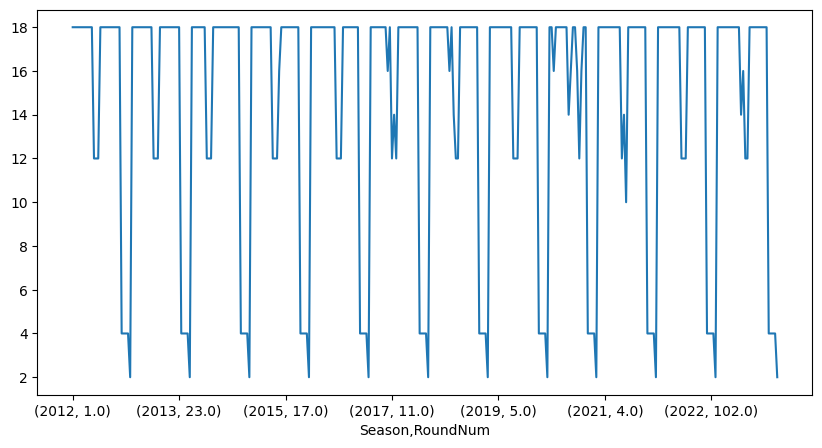

In [9]:
df_matches[['Season','RoundNum','Date']].groupby(['Season','RoundNum']).agg('count').plot(figsize=(10,5),legend=False)

### Volumes over time (By Season)

<Axes: xlabel='Season'>

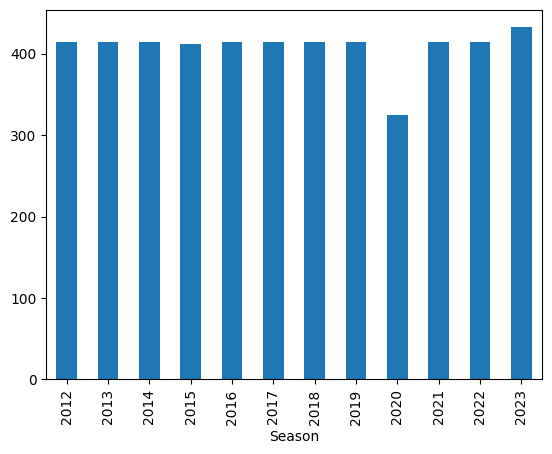

In [10]:
df_matches[['Season','Date']].groupby(['Season']).agg('count').plot(kind='bar',legend=False)

Decrease in Volumes for 2020, likely associated with the pandemic

## Numeric Values

### Mean Values over time

In [11]:
df_matches_temp = df_matches.copy(deep=True)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = df_matches_temp.select_dtypes(include=numerics).columns.to_list()

df_numeric = df_matches_temp[num_cols]

In [12]:
df_numeric.columns

Index(['PointsF', 'PointsA', 'Season', 'Attendance', 'Outcome', 'Rain (mm)',
       'Max Temp (C)', 'Min Temp (C)', 'Max Humid (%)', 'Min Humid (%)',
       'Wind Speed (m/s)', 'Solar Rad (MJ/sq m)', 'RoundNum'],
      dtype='object')

In [13]:
#Prepare for plotting and aggregate 
df_num_means = df_numeric.groupby(['Season','RoundNum']).agg('mean')
#Remove the tiome variables from the list for looping
num_cols.remove('Season')
num_cols.remove('RoundNum')

#### Aggregate by Round

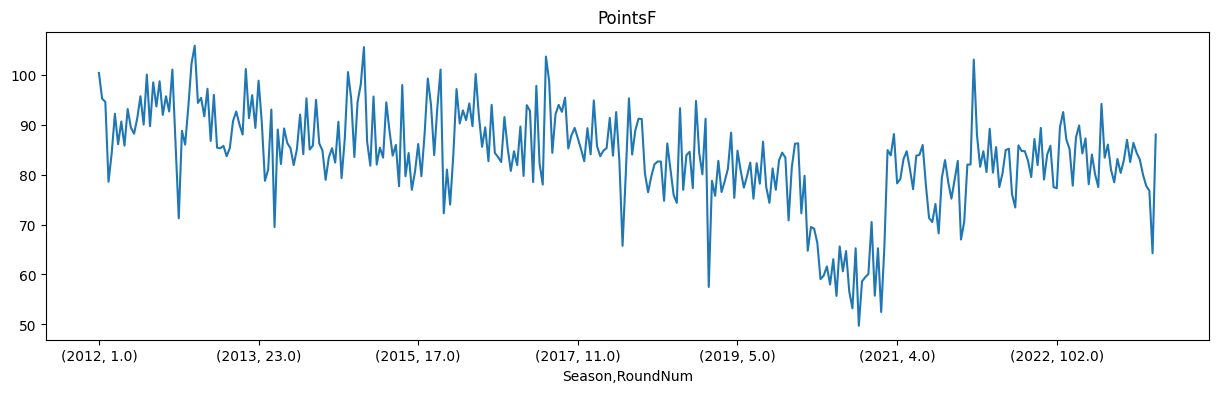

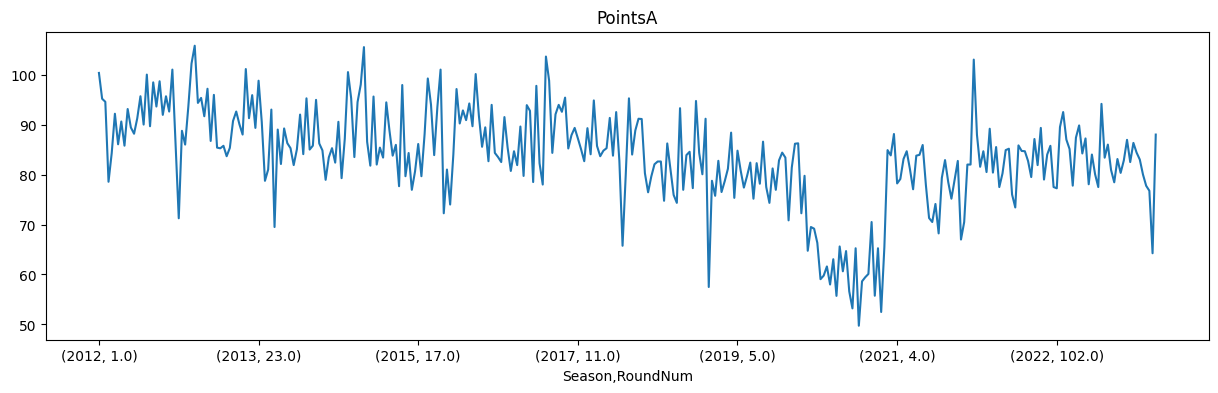

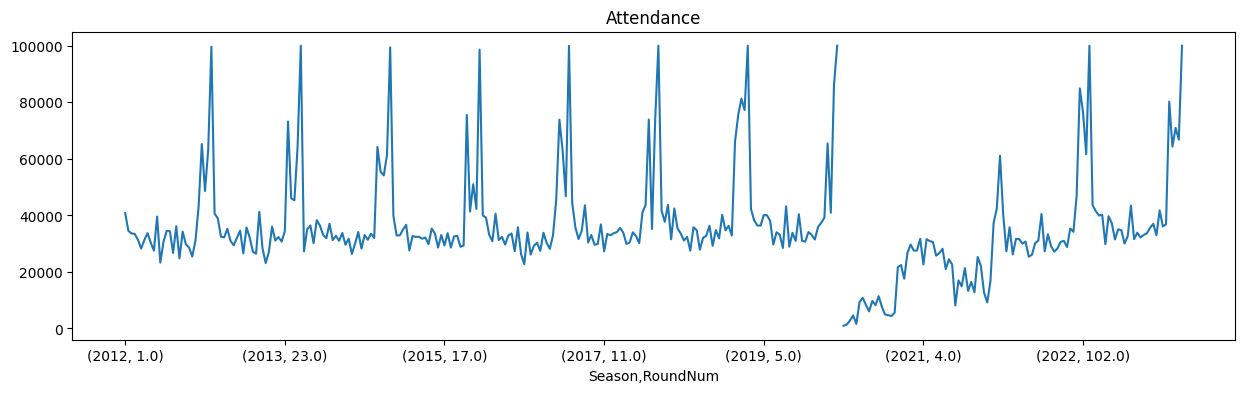

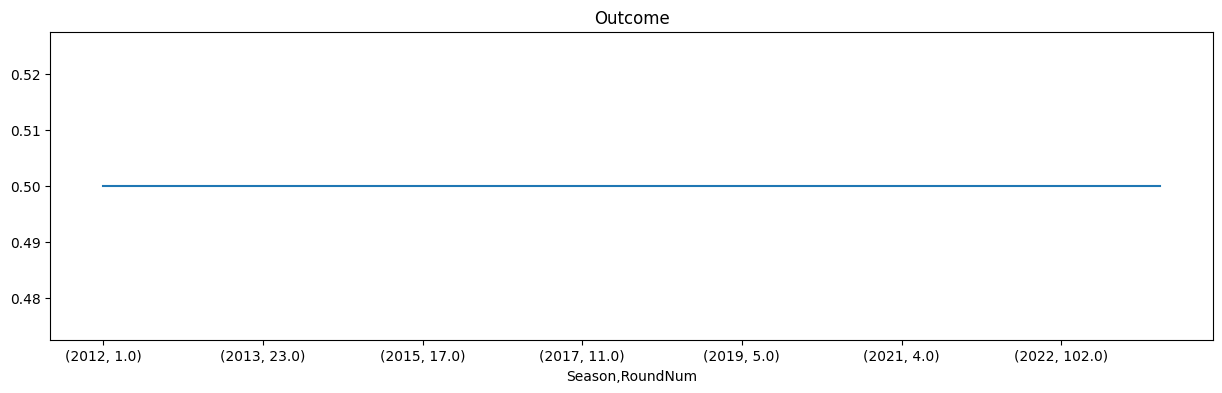

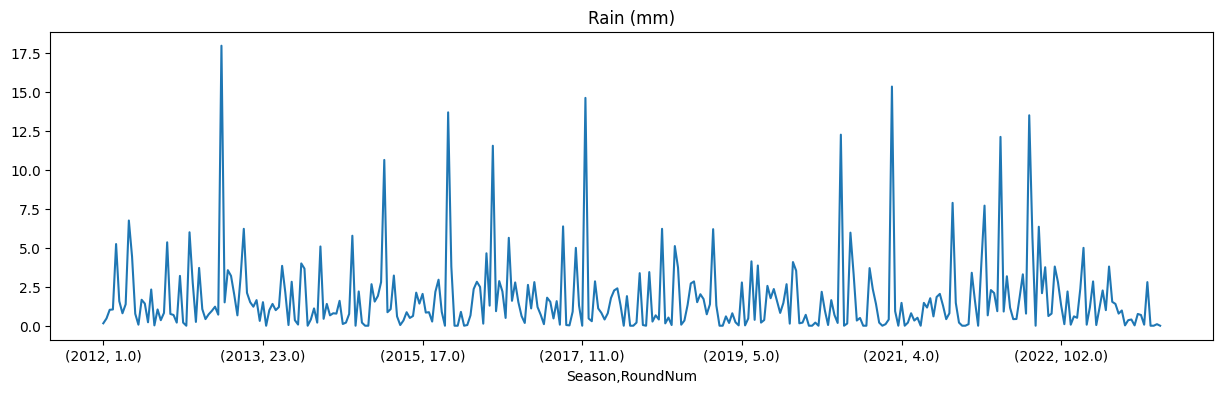

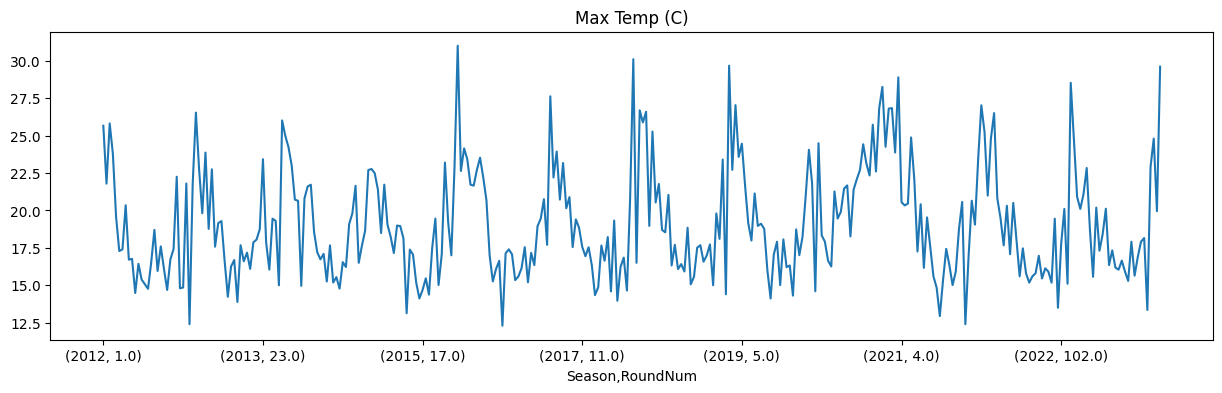

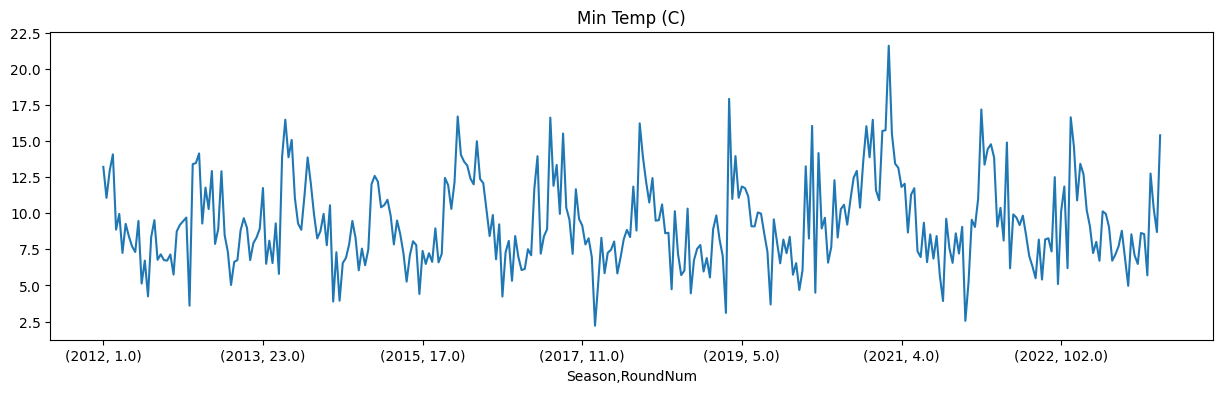

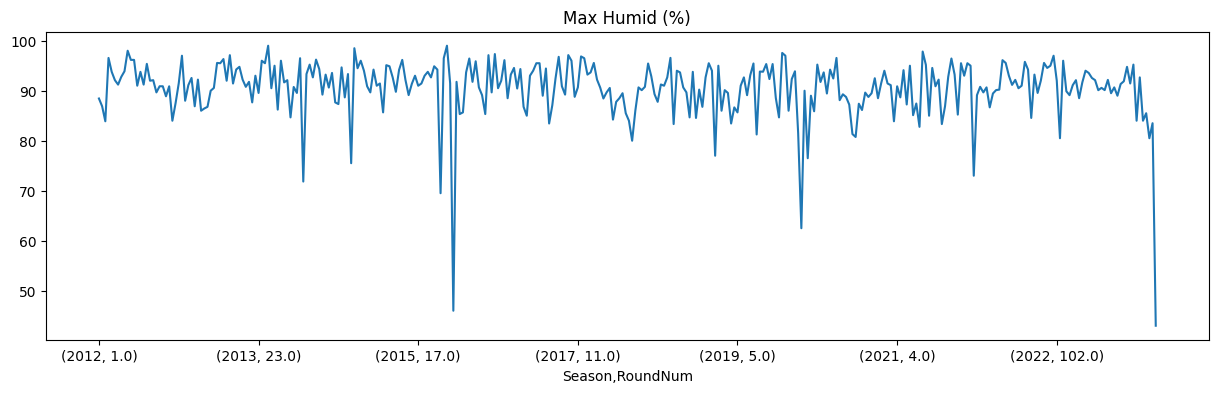

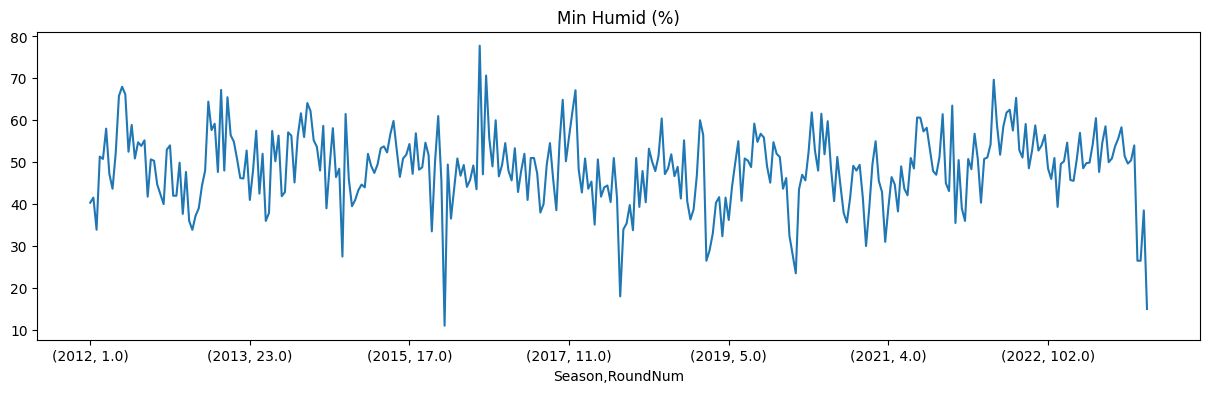

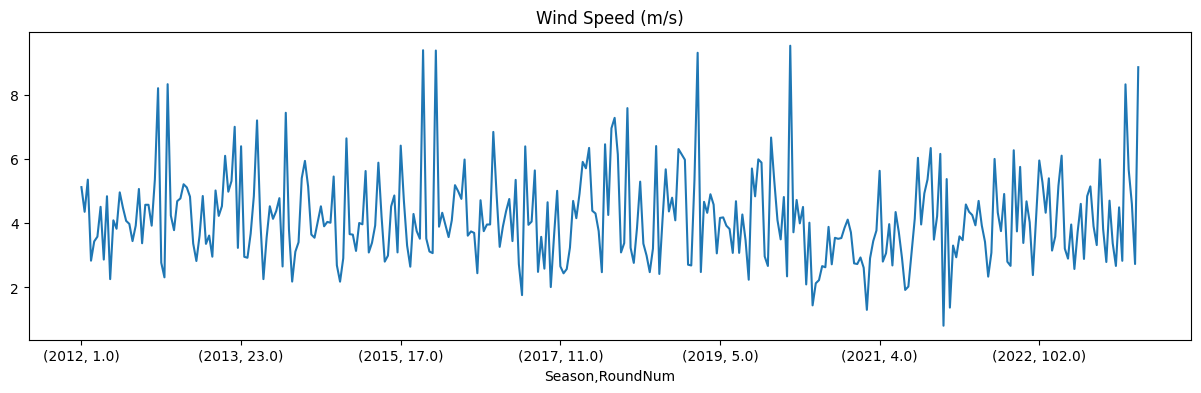

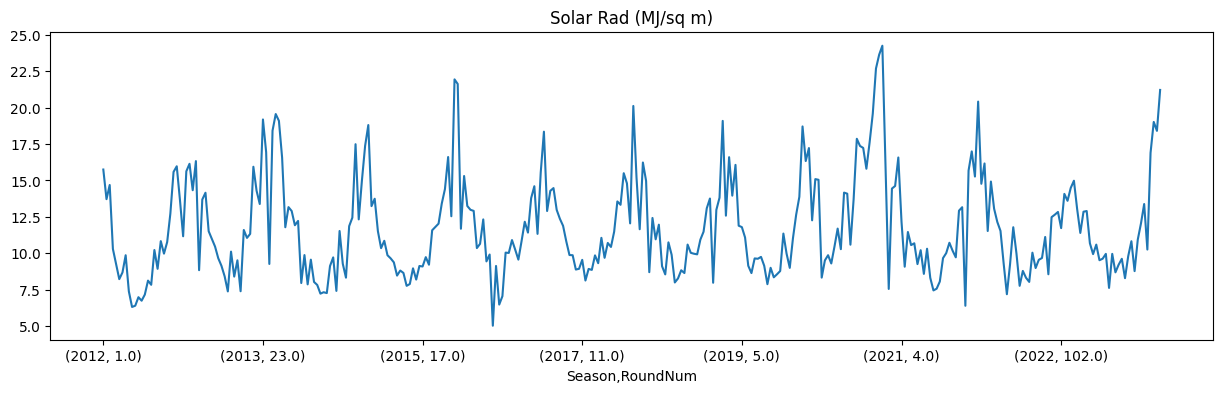

In [14]:
for val in num_cols:
    plt.figure(figsize=(15,4))
    plt.title(val)
    df_num_means[val].plot()

#### Aggregate by Season 

In [15]:
#Prepare for plotting and aggregate 
df_num_means = df_numeric.drop('RoundNum',axis=1).groupby('Season').agg('mean')

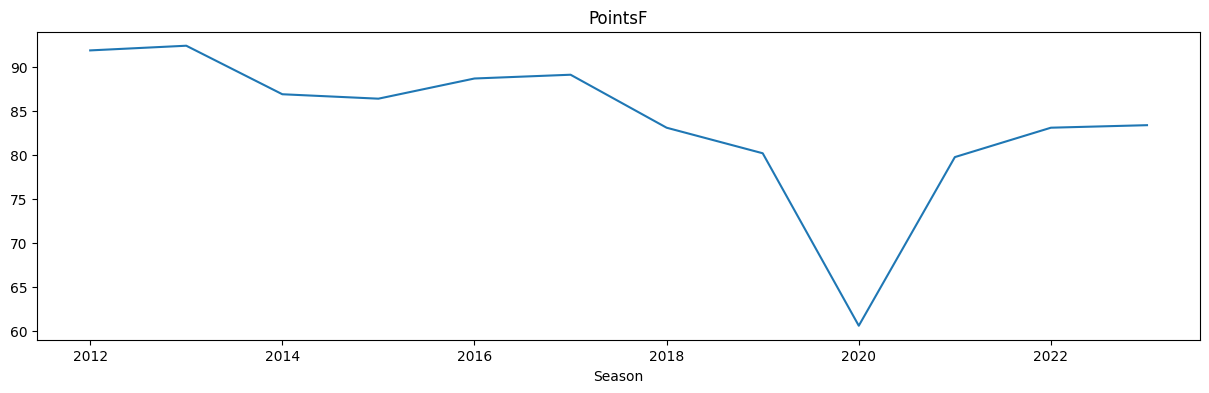

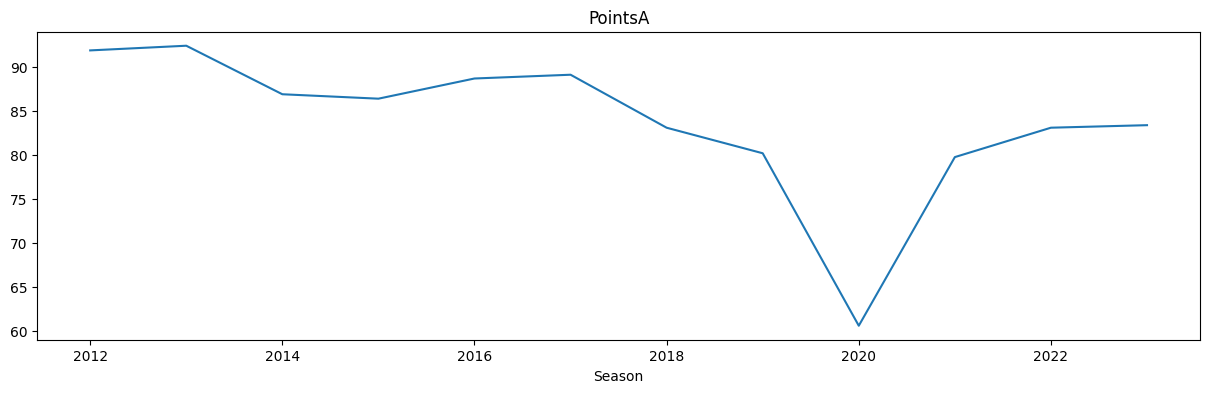

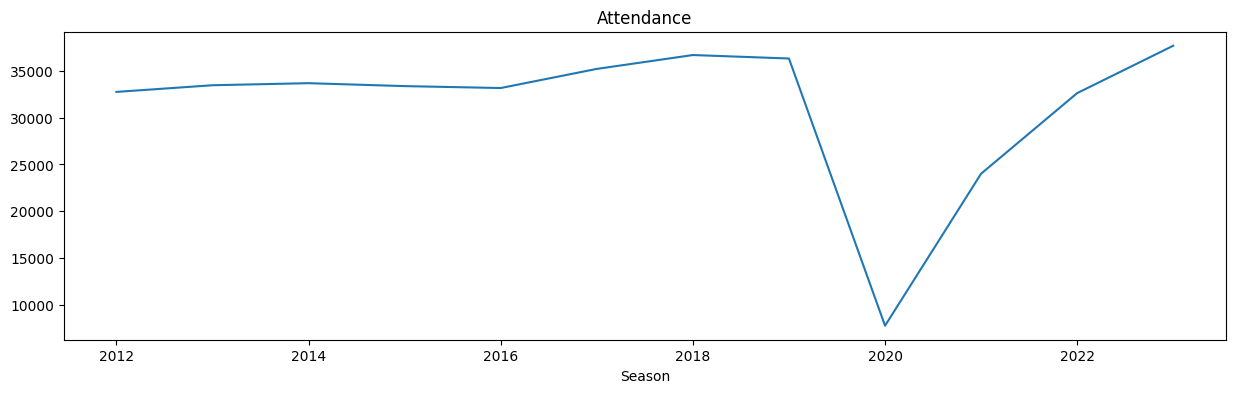

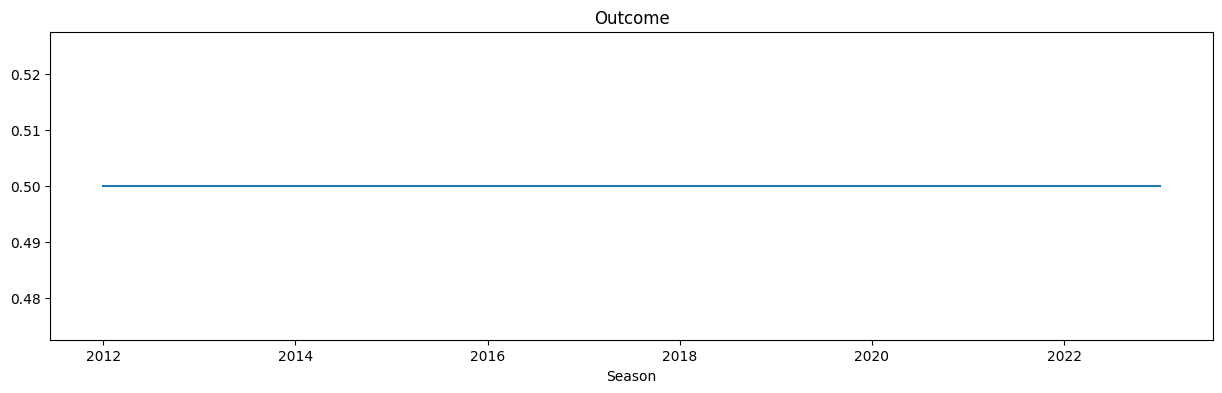

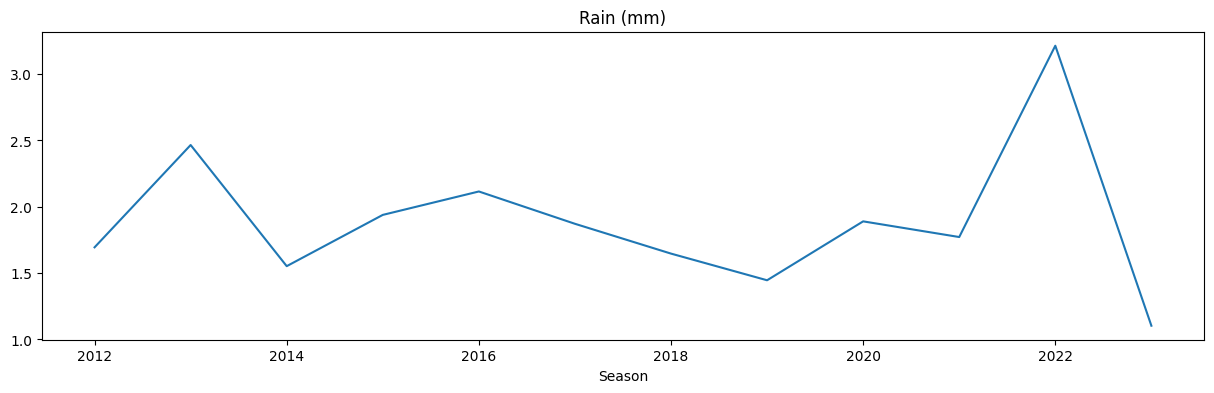

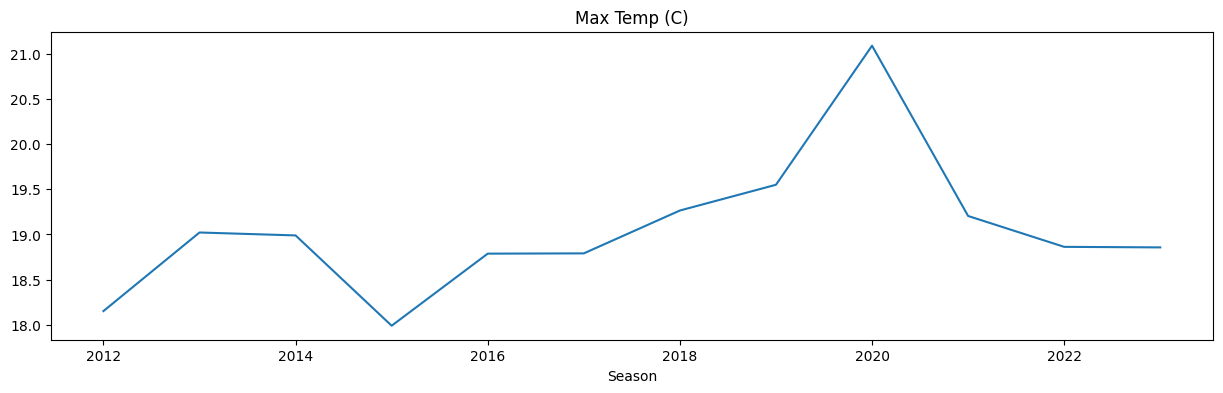

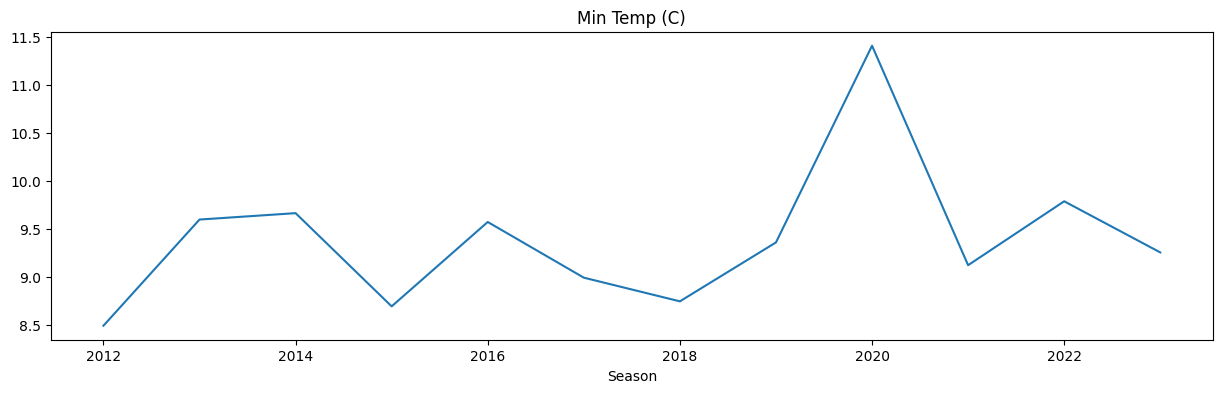

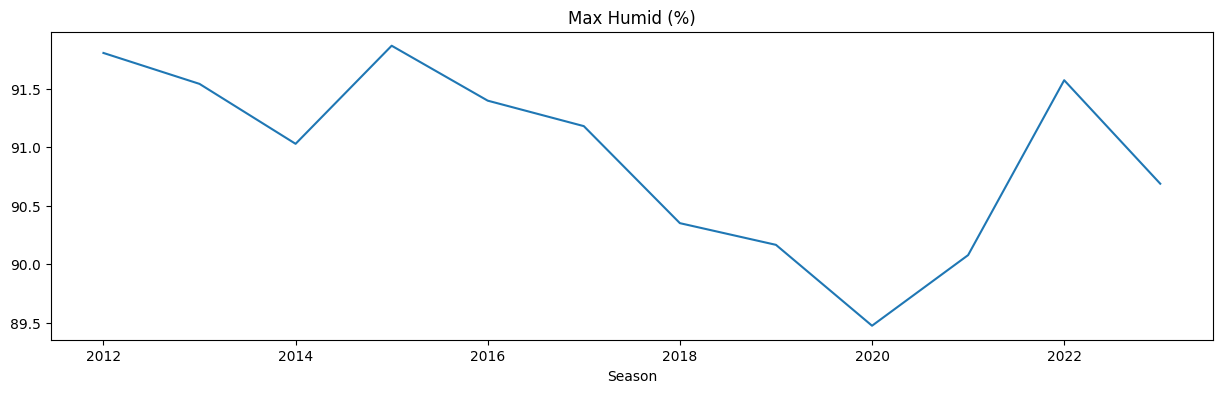

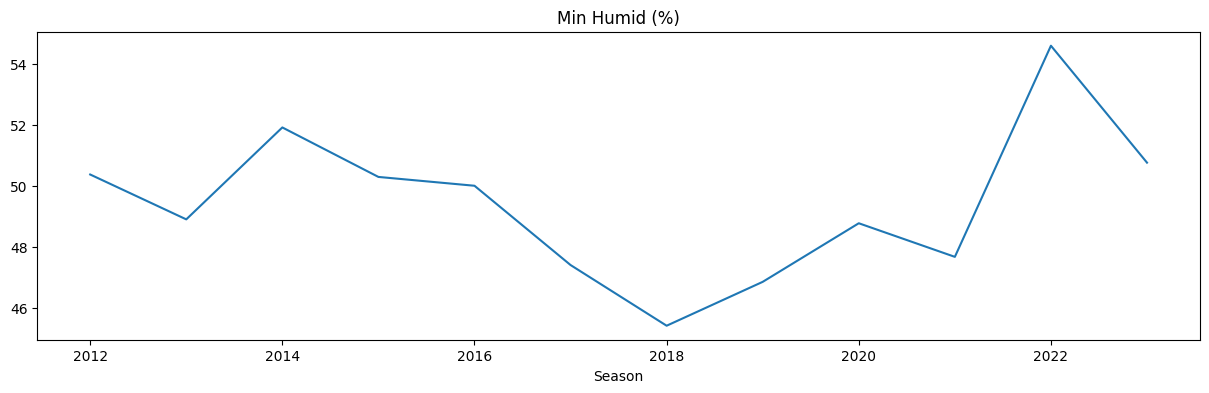

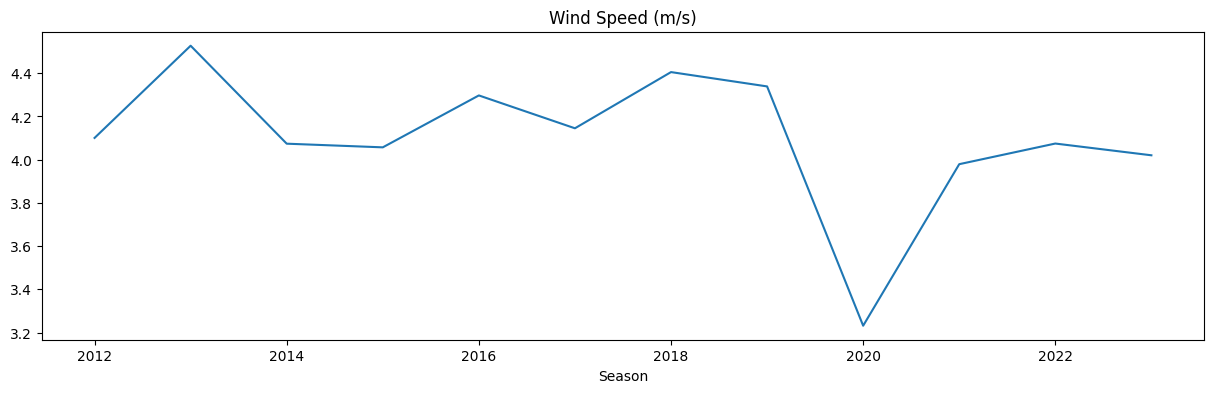

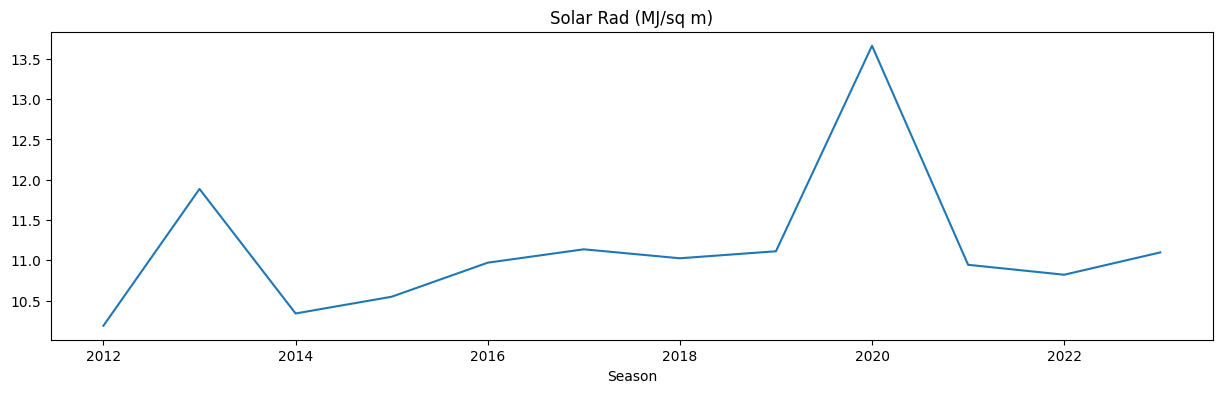

In [16]:
for val in num_cols:
    plt.figure(figsize=(15,4))
    plt.title(val)
    df_num_means[val].plot()

Variables appear as expected, with cyclical variation in weather related data (especially temperature). Attendance is seen to sharply decline around 2020 and slowly ramp back up (COVID-19)

### Missing Rates over Time

In [17]:
#Create flag for missing values
for val in num_cols:
    df_numeric[val+'_missing'] = df_numeric[val].isna().astype(int)
    
#Create a selection vector for the '_missing' vars
num_cols_miss = [val+'_missing' for val in num_cols]
#Append Season and RoundNum
num_cols_miss.append('Season')
num_cols_miss.append('RoundNum')

C:\Users\Adam\AppData\Local\Temp\ipykernel_99280\798053838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Adam\AppData\Local\Temp\ipykernel_99280\798053838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Adam\AppData\Local\Temp\ipykernel_99280\798053838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

#### Aggregate By Round

In [18]:
#Prepare for plotting and aggregate 
df_num_miss = df_numeric[num_cols_miss].groupby(['Season','RoundNum']).agg('mean')
#Remove the tiome variables from the list for looping
num_cols_miss.remove('Season')
num_cols_miss.remove('RoundNum')

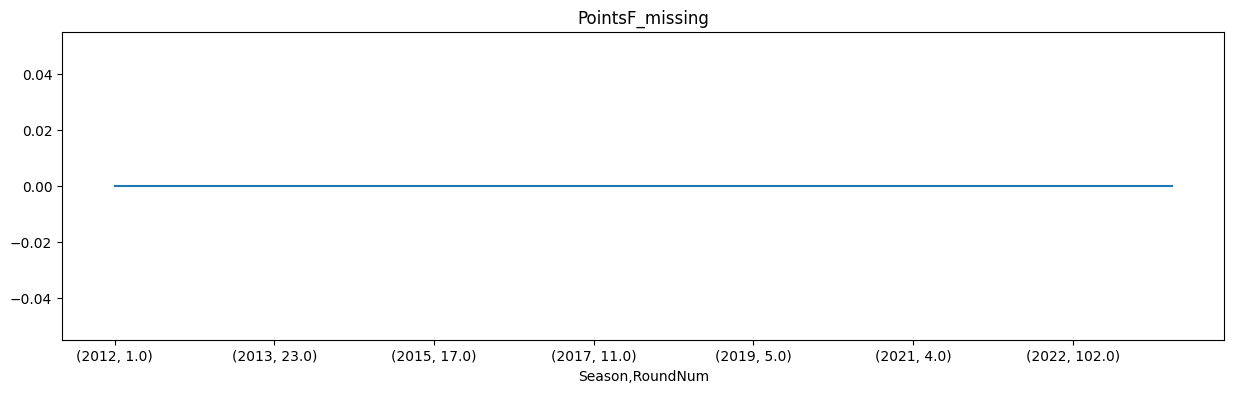

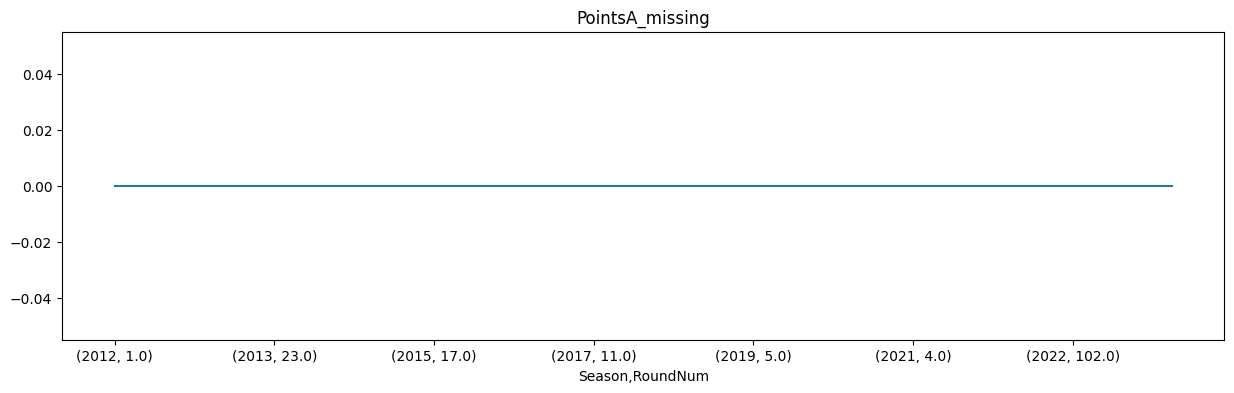

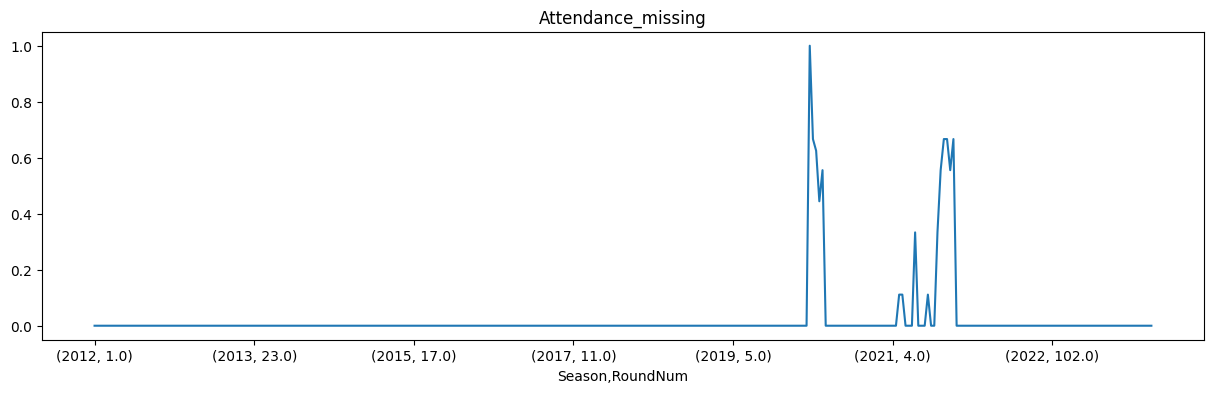

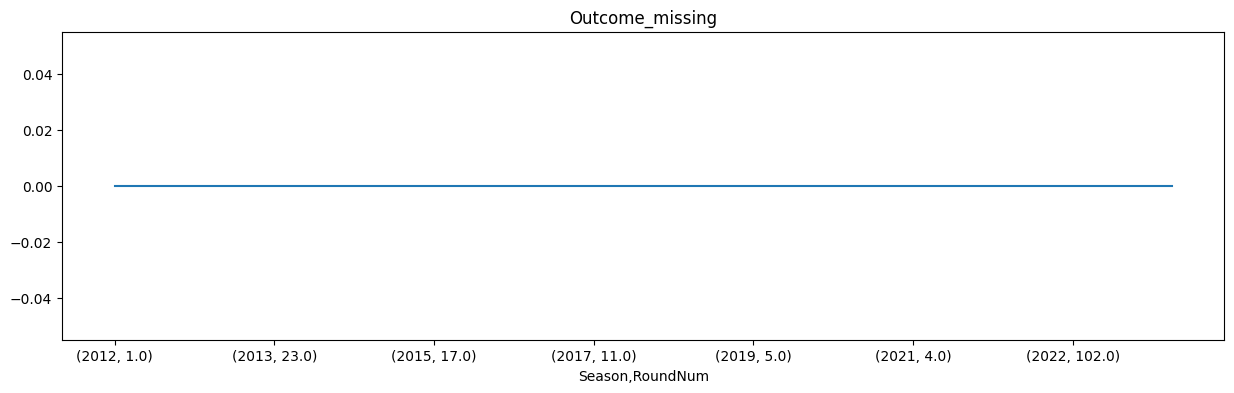

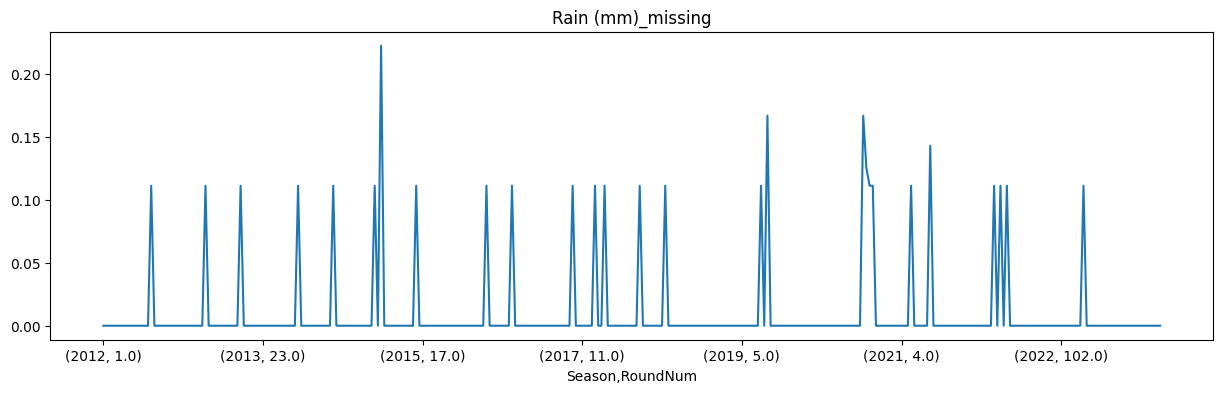

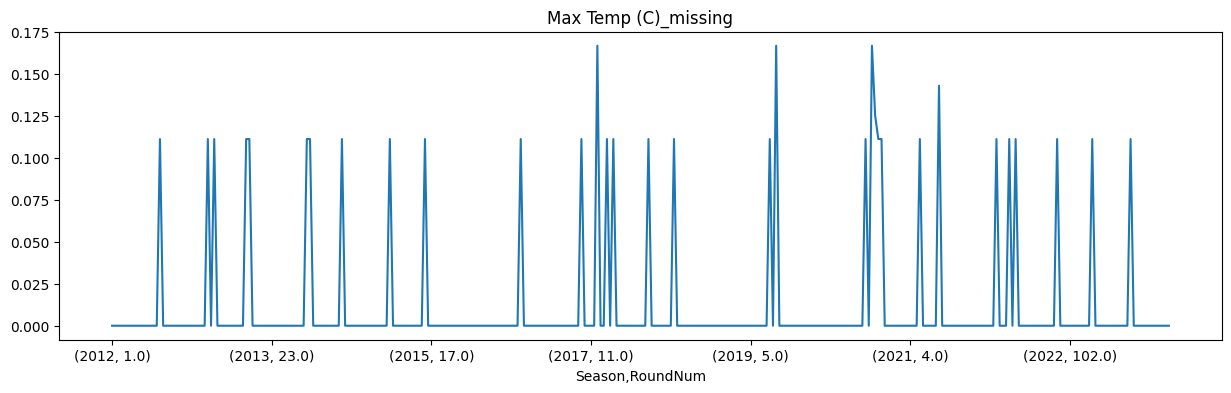

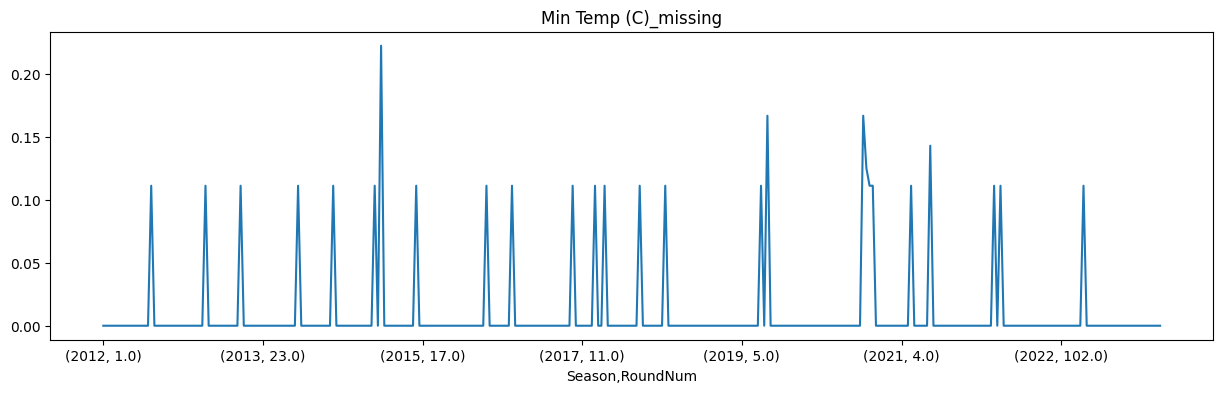

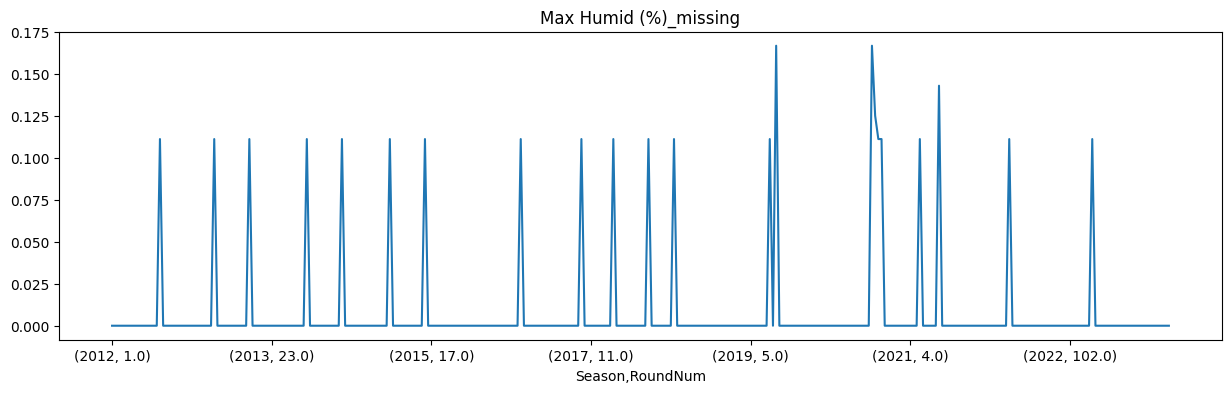

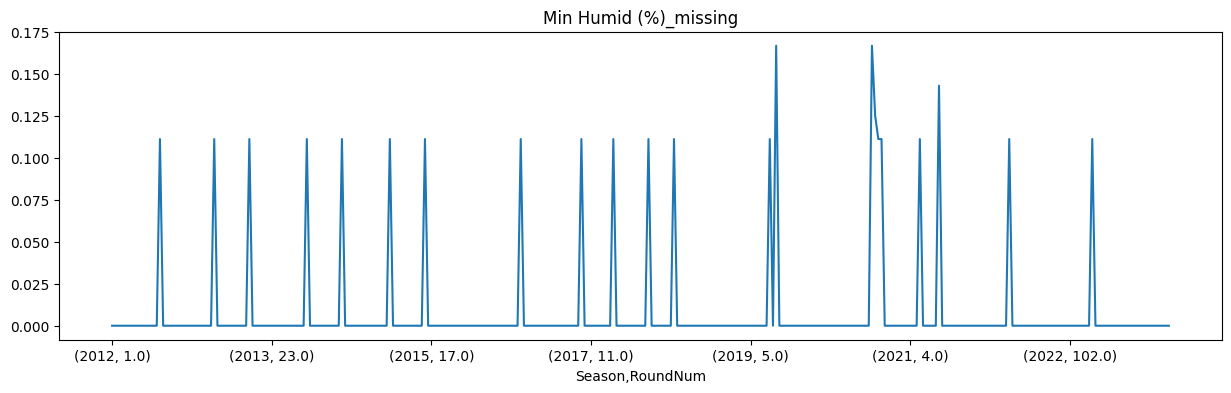

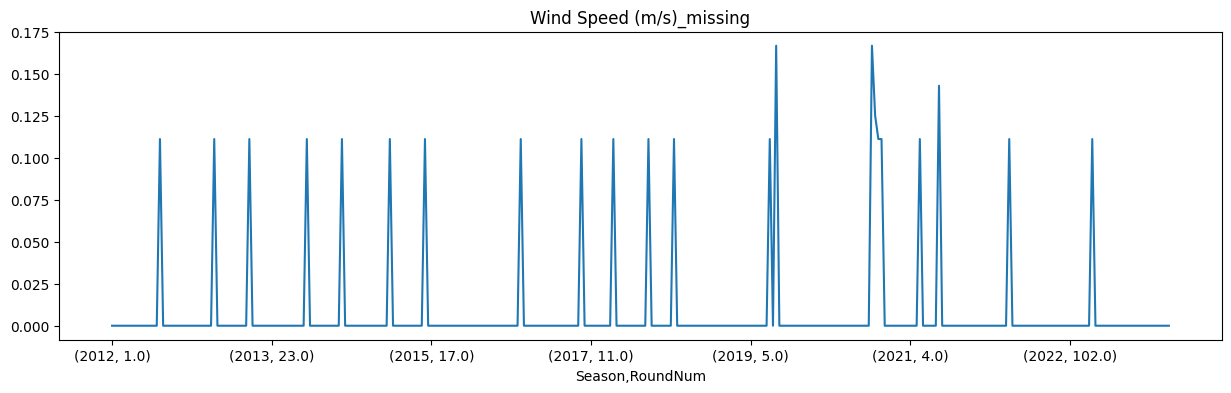

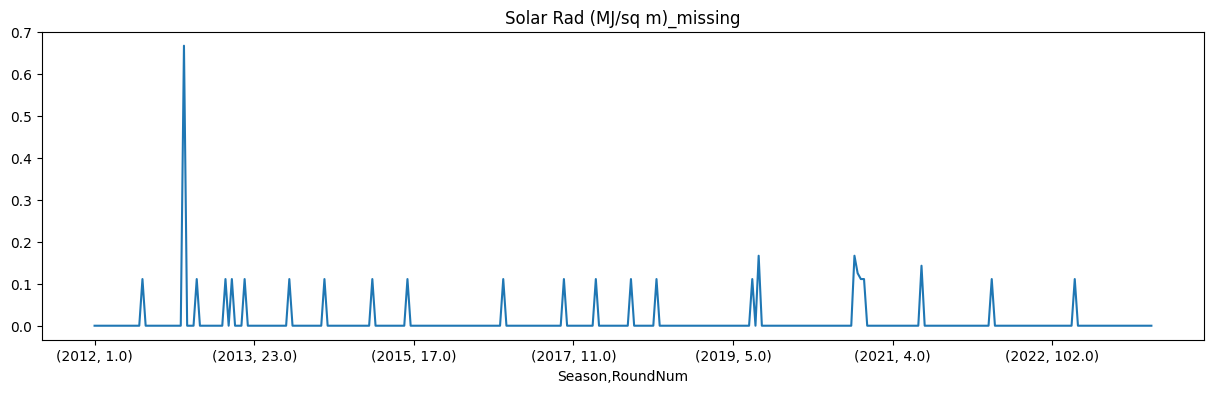

In [19]:
for val in num_cols_miss:
    plt.figure(figsize=(15,4))
    plt.title(val)
    df_num_miss[val].plot()

#### Aggregate By Season

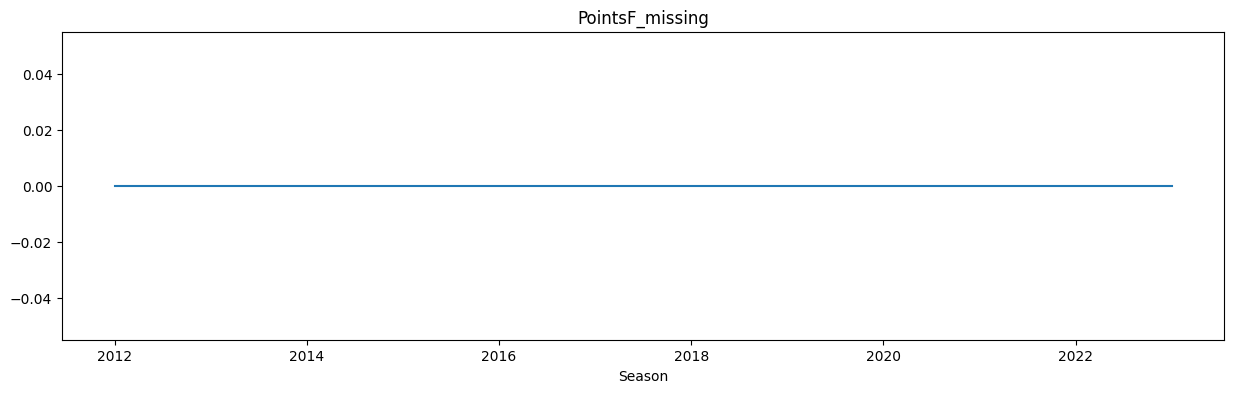

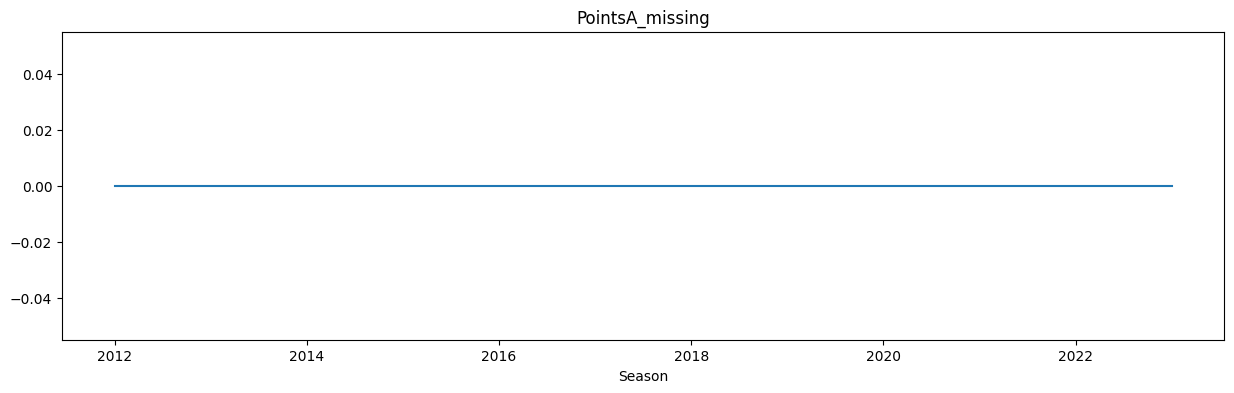

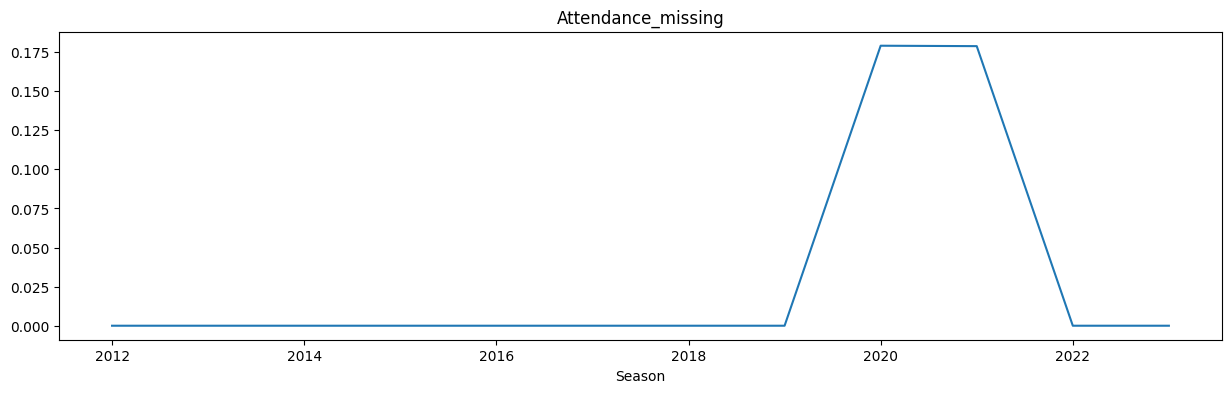

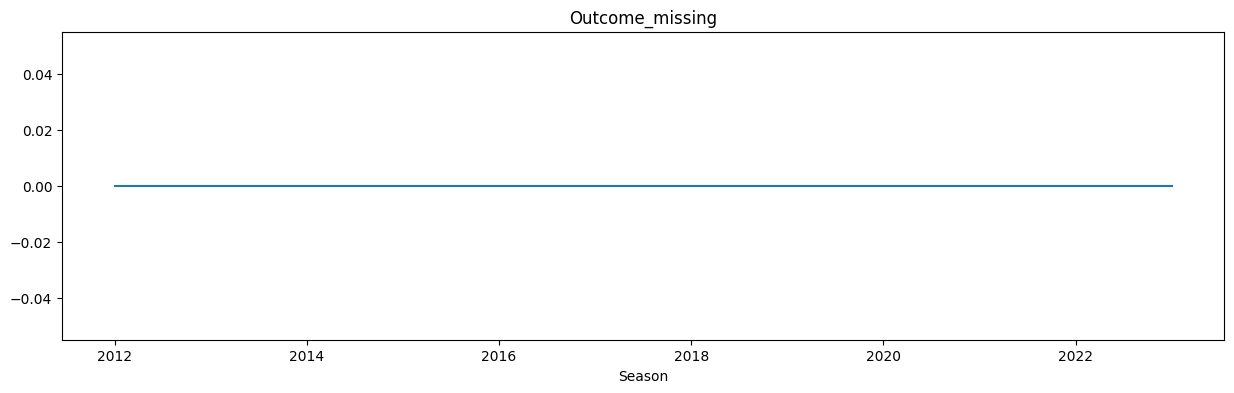

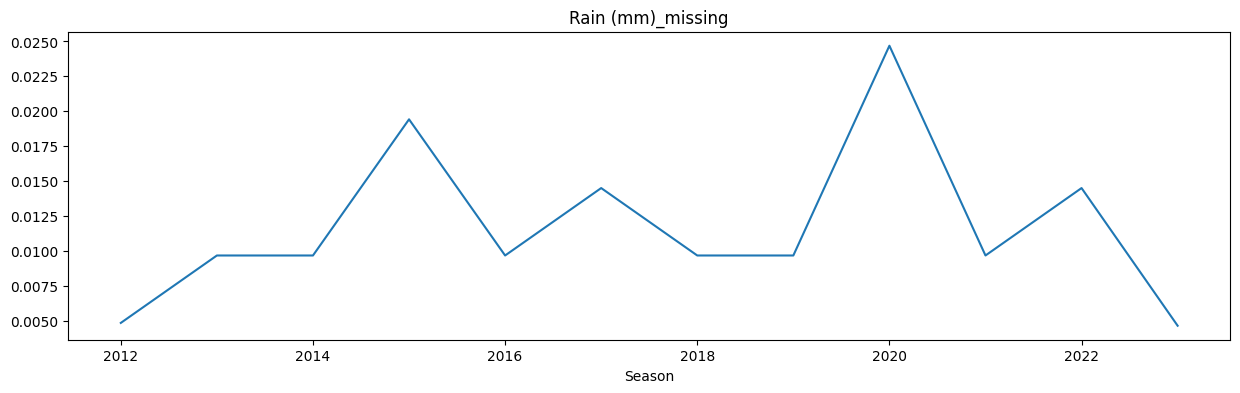

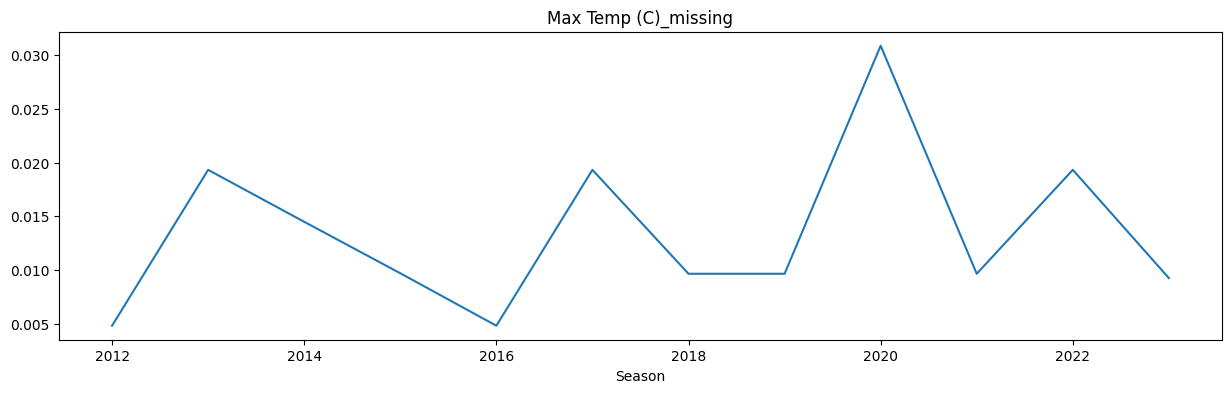

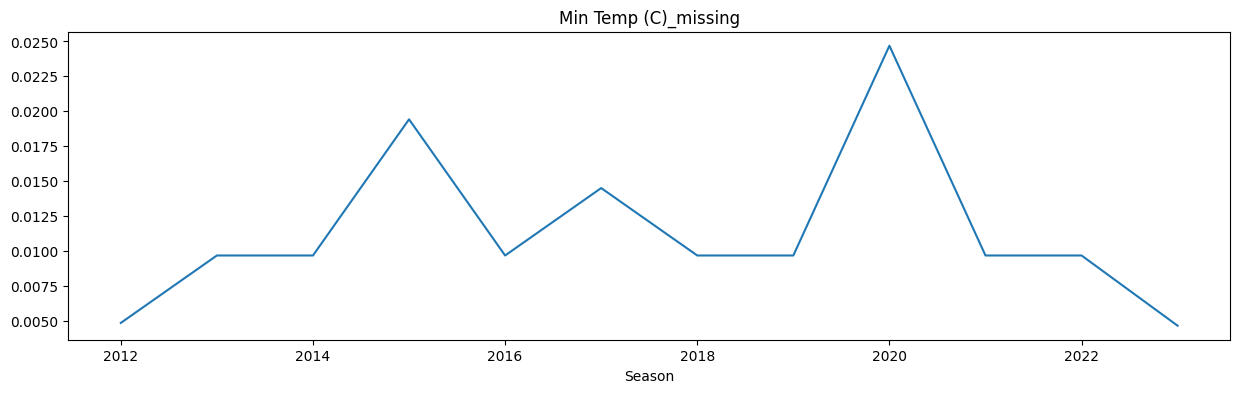

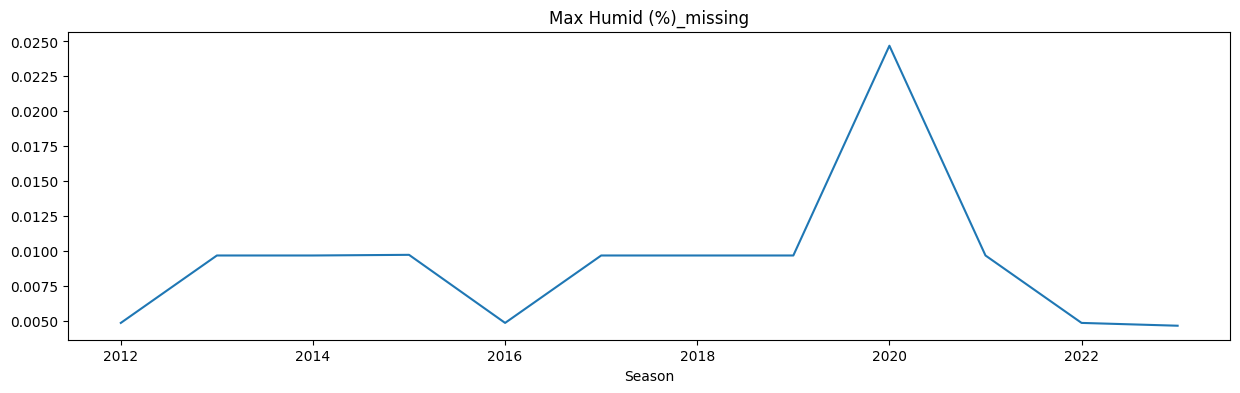

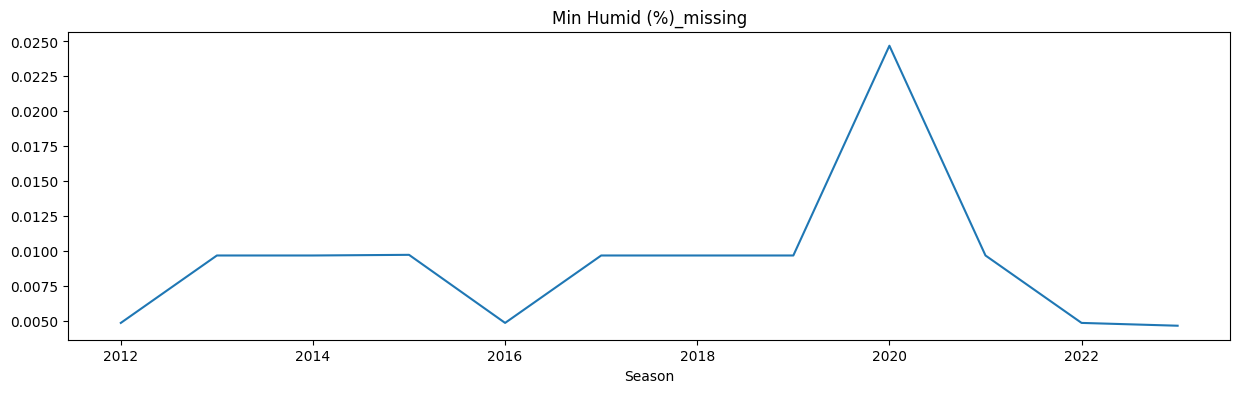

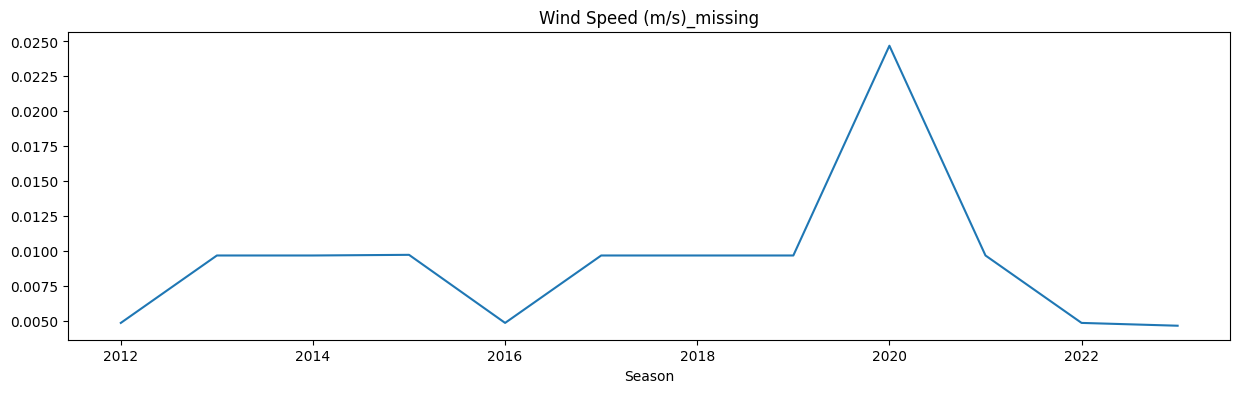

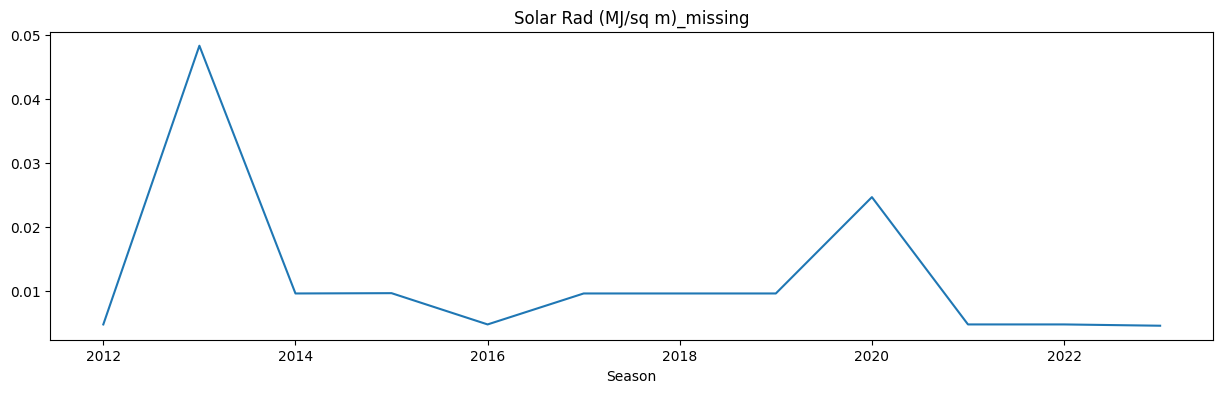

In [20]:
#Append Season
num_cols_miss.append('Season')
#Prepare for plotting and aggregate 
df_num_miss = df_numeric[num_cols_miss].groupby('Season').agg('mean')
#Remove the tiome variables from the list for looping
num_cols_miss.remove('Season')
for val in num_cols_miss:
    plt.figure(figsize=(15,4))
    plt.title(val)
    df_num_miss[val].plot()


Attendance missing rates primarily focussed around 2020-2021, explainable by social distancing and COVID restrictions. Missing rates in Rainfall warrant further investigation.

In [21]:
df_matches[df_matches['Rain (mm)'].isna()].Venue.value_counts()

Venue
Cazaly's Stadium      26
Wellington             6
Jiangwan Stadium       6
Kardinia Park          4
Carrara                4
Riverway Stadium       2
Bellerive Oval         2
Perth Stadium          2
Sydney Showground      2
Summit Sports Park     2
Name: count, dtype: int64

In [22]:
df_matches[df_matches['Rain (mm)'].isna()].Season.value_counts().sort_index()

Season
2012    2
2013    4
2014    4
2015    8
2016    4
2017    6
2018    4
2019    4
2020    8
2021    4
2022    6
2023    2
Name: count, dtype: int64

Small amounts of missing data in areas weather has not been obtained for. Future fix if required is to add weather data for the Cazaly's Stadium area.

### Outlier Checks by Season

In [23]:
#Add Season back to the numeric cols list
num_cols.append('Season')
df_numeric_box = df_numeric[num_cols]
num_cols.remove('Season')
df_numeric_box = df_numeric_box.dropna()

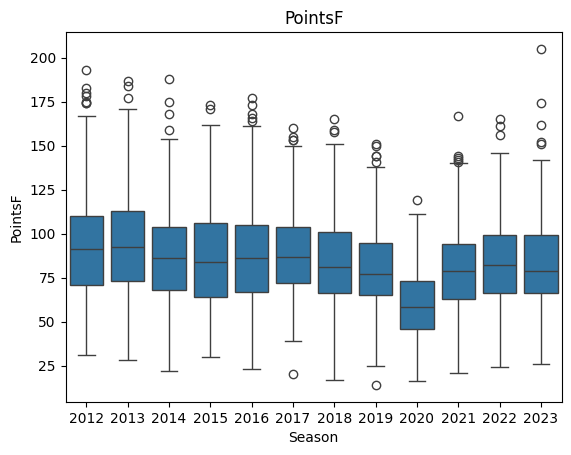

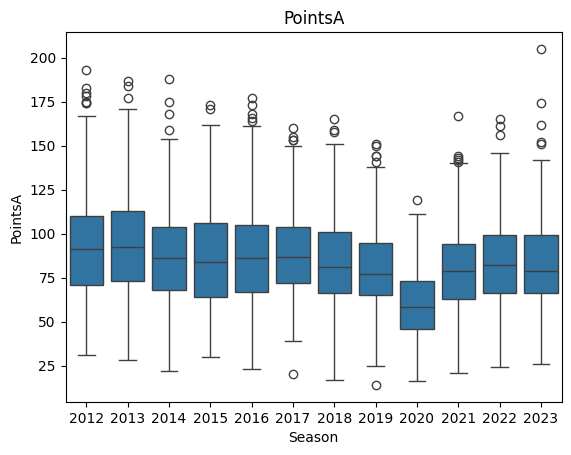

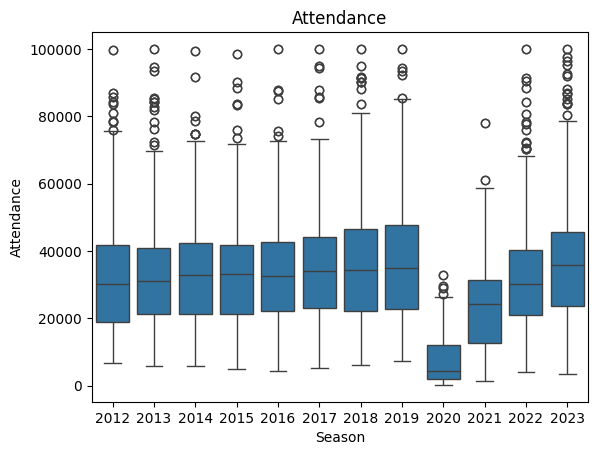

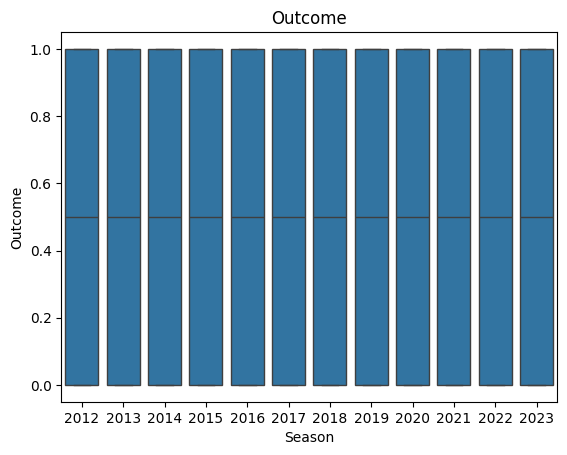

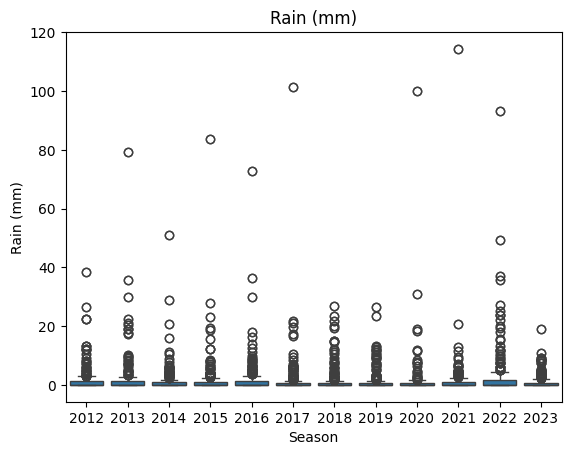

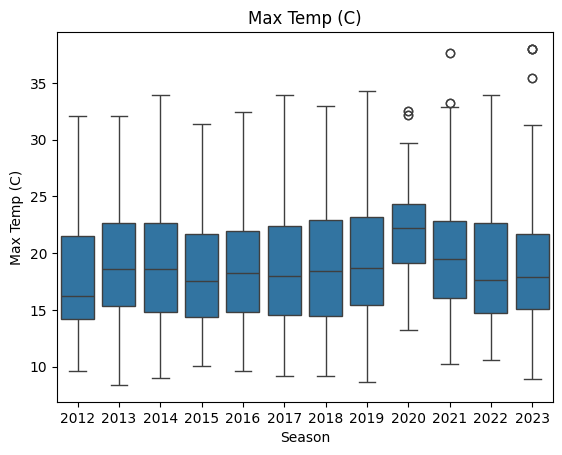

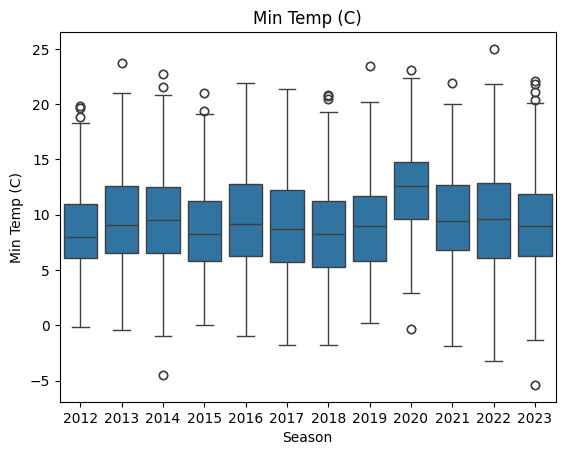

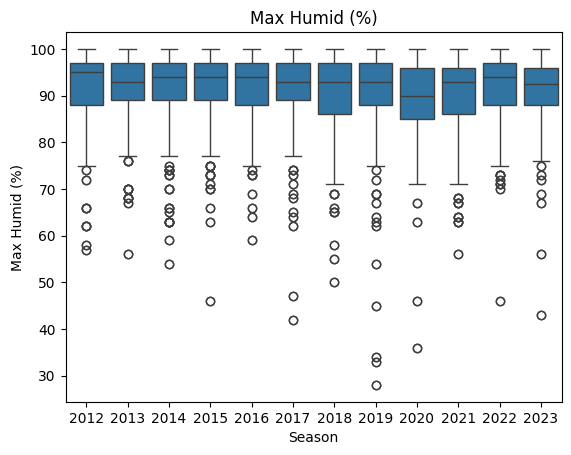

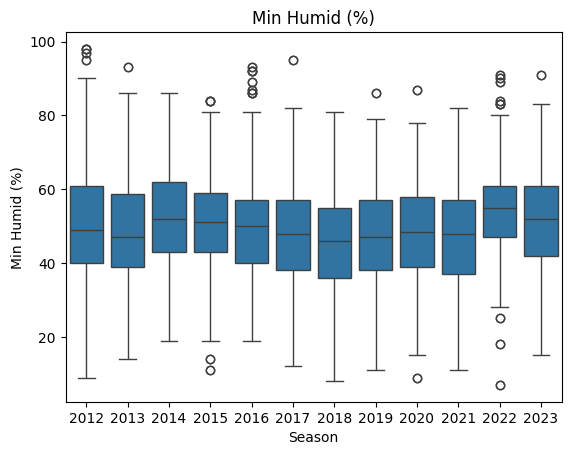

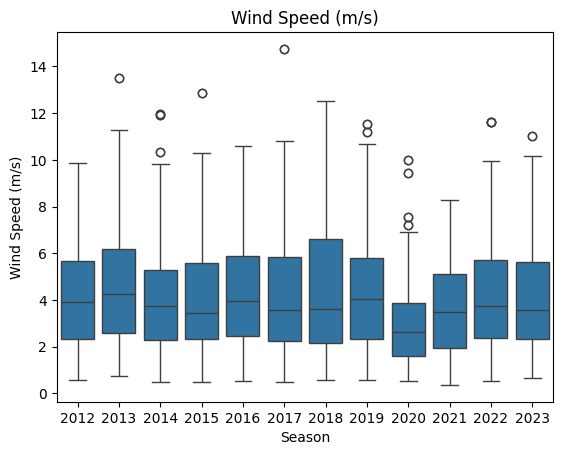

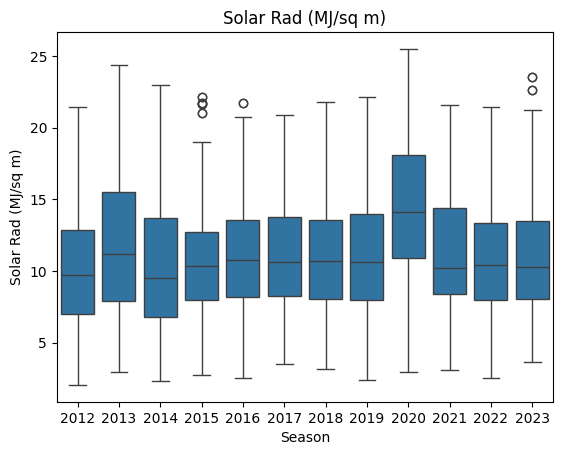

In [24]:
#Create boxplots over time for each numeric variable
for val in num_cols:
    plt.figure()
    plt.title(val)
    sns.boxplot(data=df_numeric_box.dropna(),x='Season',y=val)

Weather events seem most susceptible to outliers, however this is to be expected

## Categorical Variables

In [33]:
cat_vars = ['Team','Opponent','Venue','Day','H/A','oppH/A']
df_cats = df_matches[['Season','Team','Opponent','Venue','Day','H/A','oppH/A','Date']]

In [41]:
df_cats['Venue'].unique()

array(['Stadium Australia', 'M.C.G.', 'Carrara', 'Subiaco', 'Docklands',
       'Football Park', 'Gabba', 'S.C.G.', 'Bellerive Oval', 'Blacktown',
       'Kardinia Park', 'Manuka Oval', 'York Park', 'Marrara Oval',
       'Sydney Showground', "Cazaly's Stadium", 'Wellington',
       'Adelaide Oval', 'Traeger Park', 'Jiangwan Stadium',
       'Eureka Stadium', 'Perth Stadium', 'Riverway Stadium',
       'Norwood Oval', 'Summit Sports Park'], dtype=object)

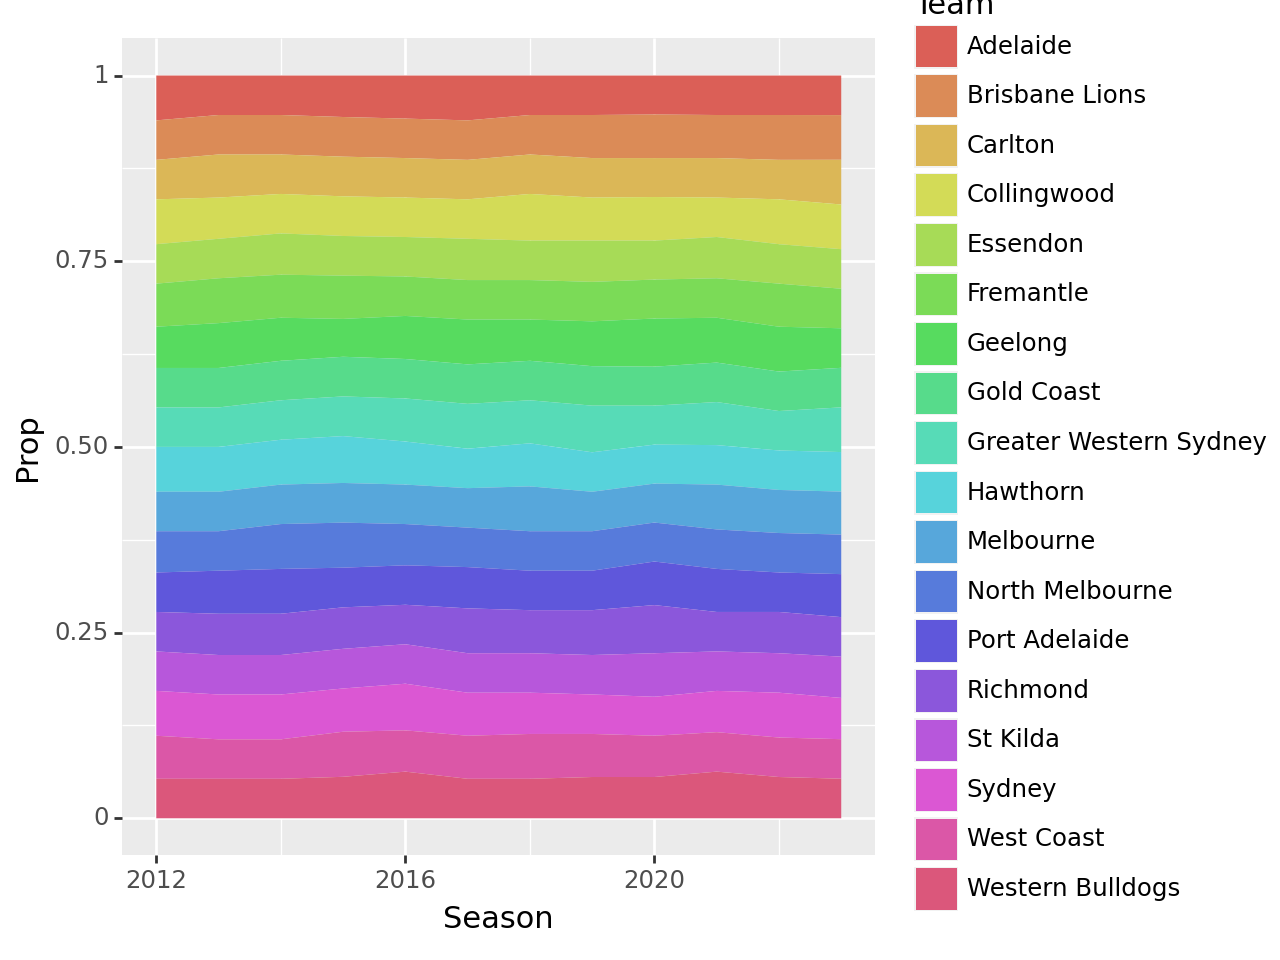

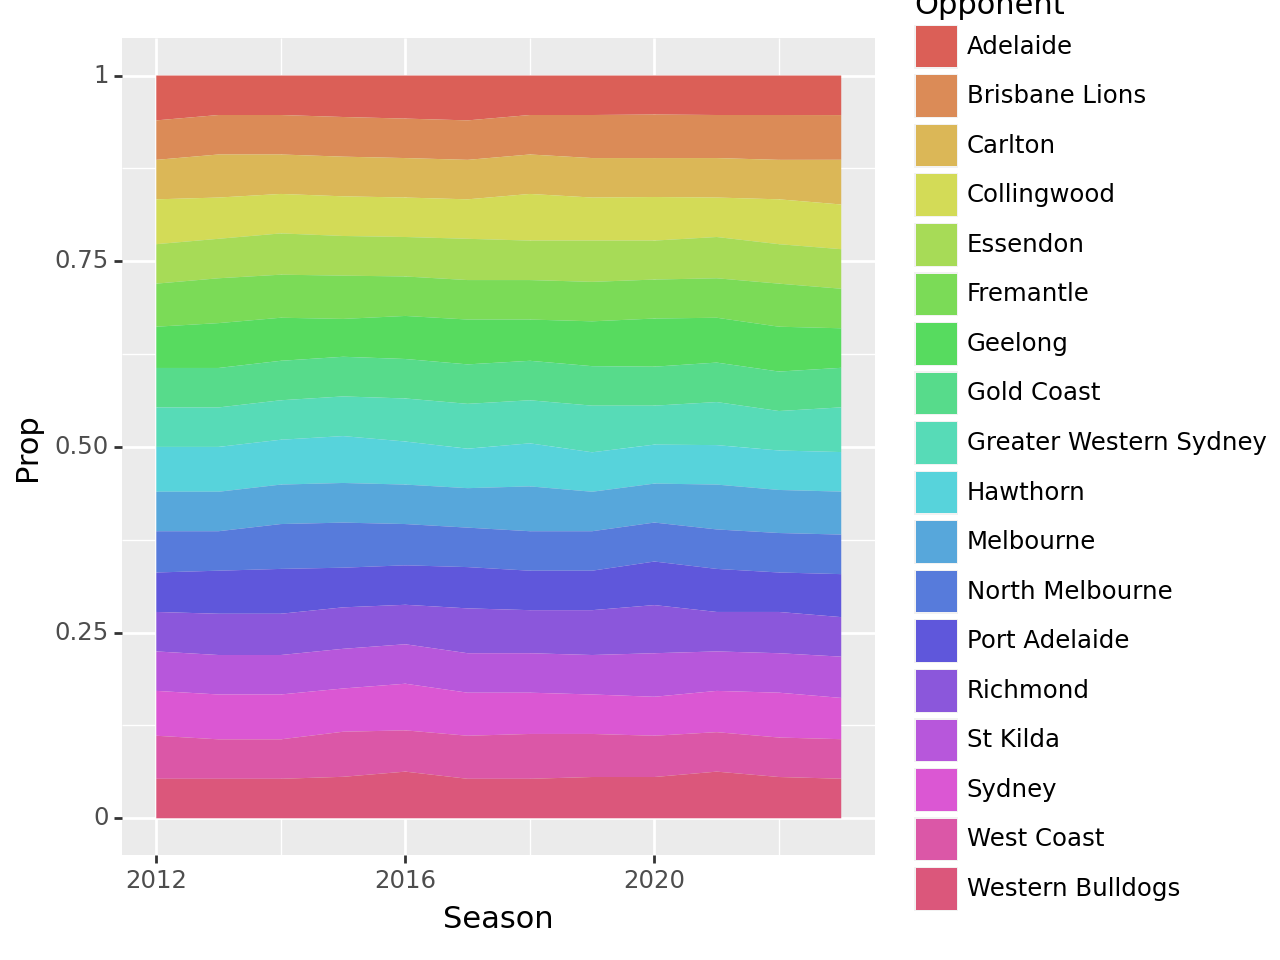

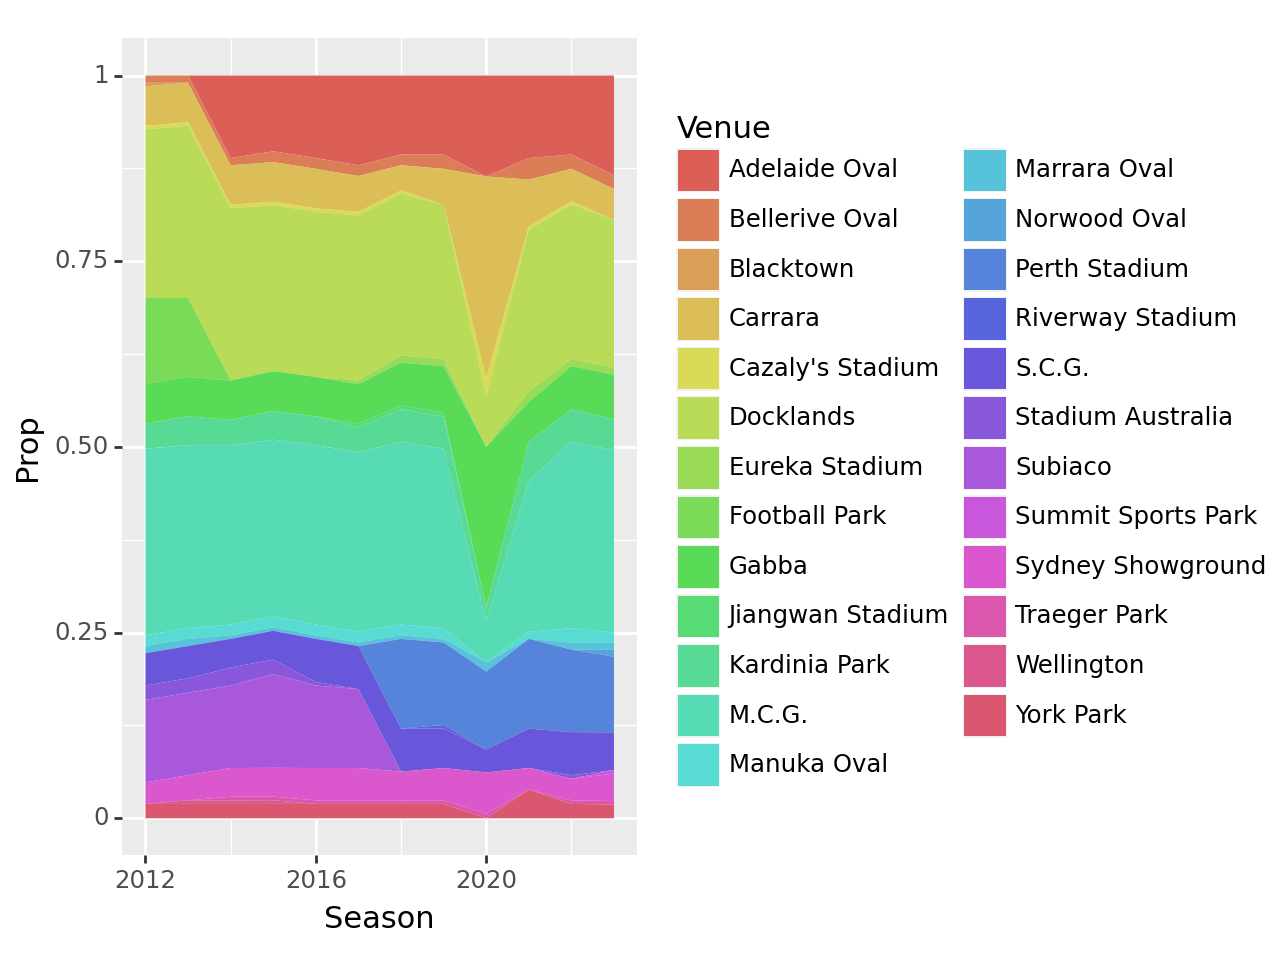

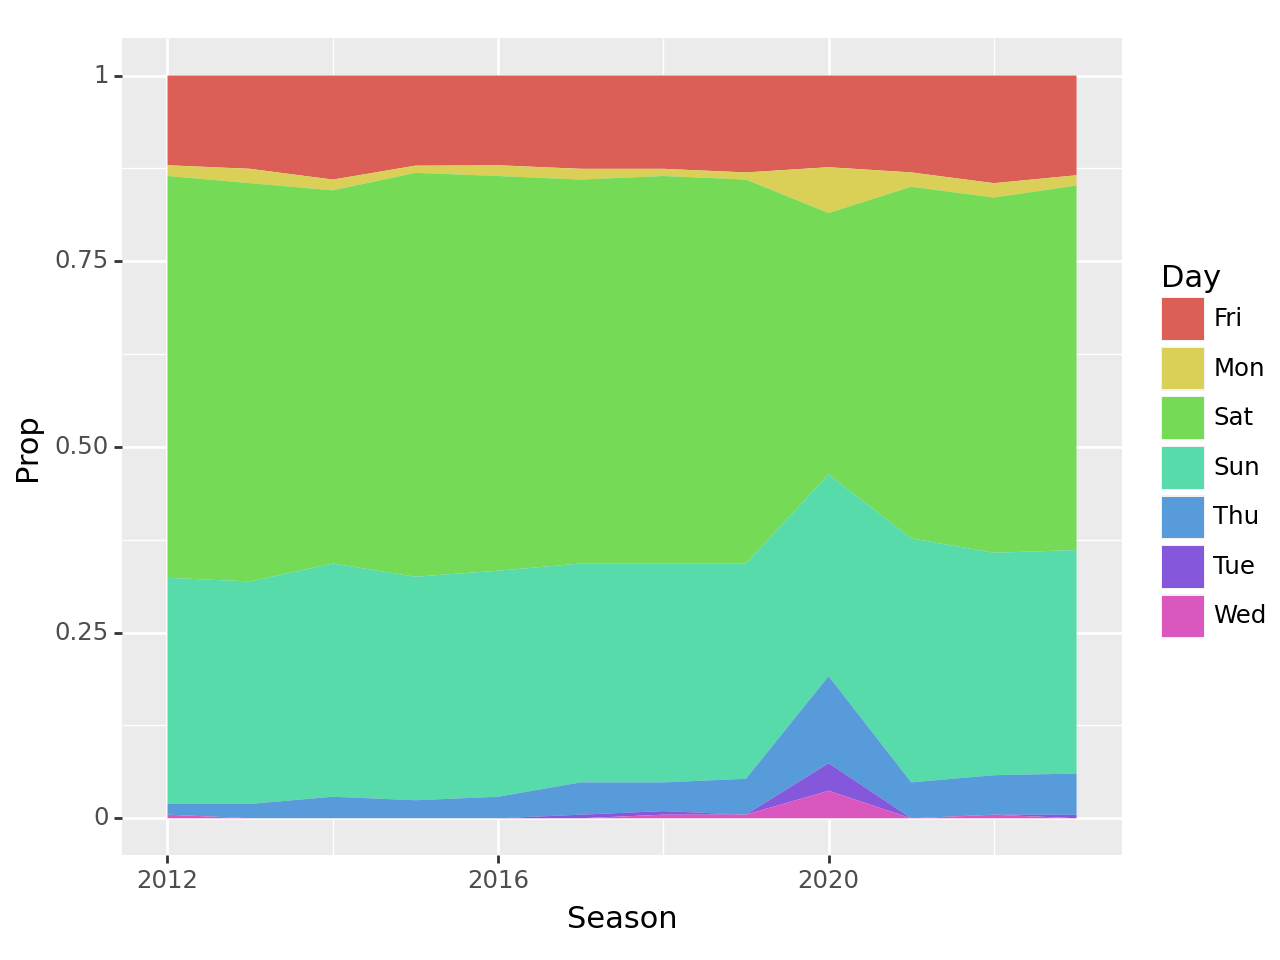

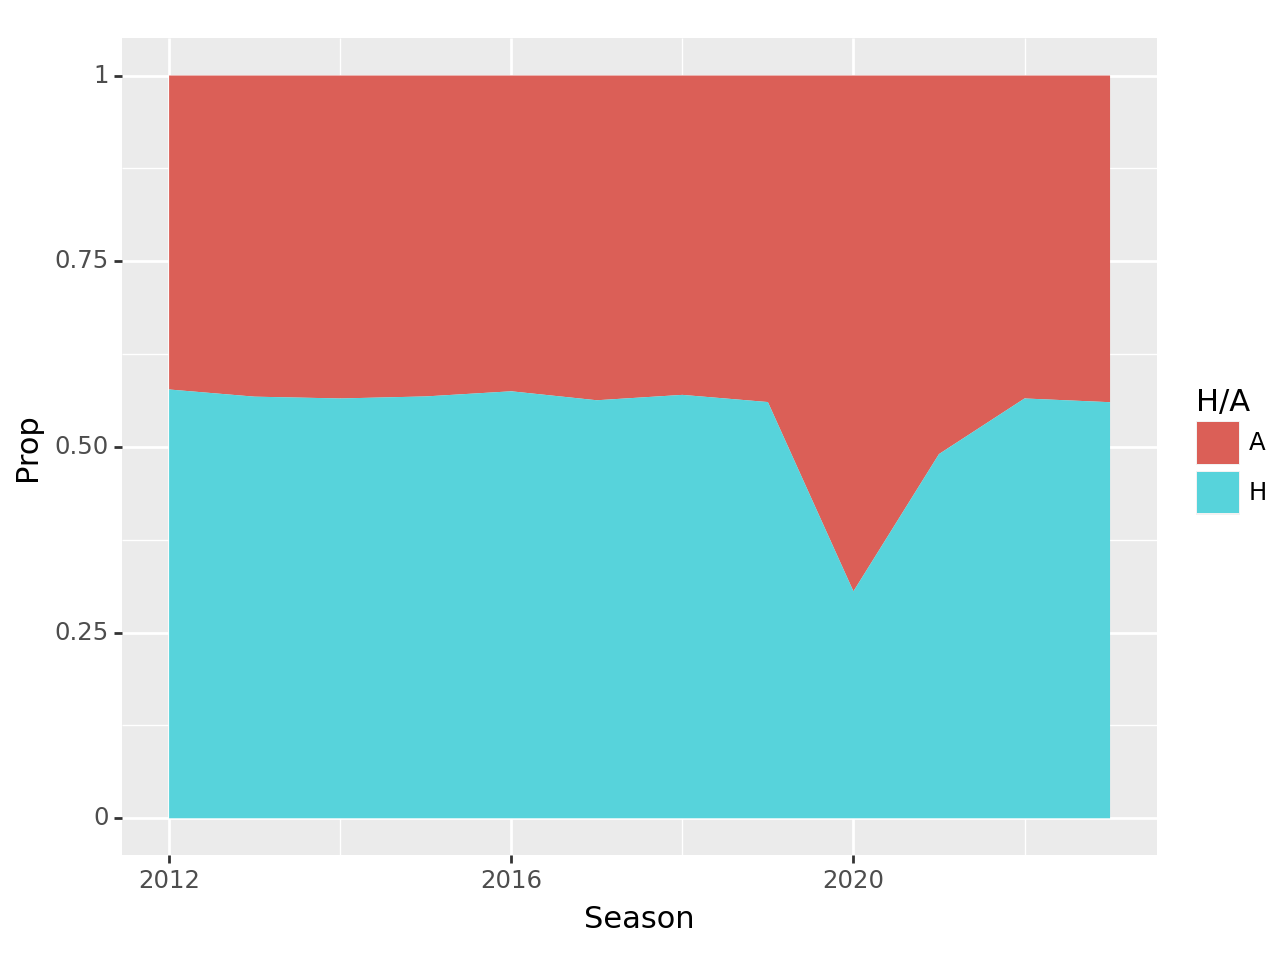

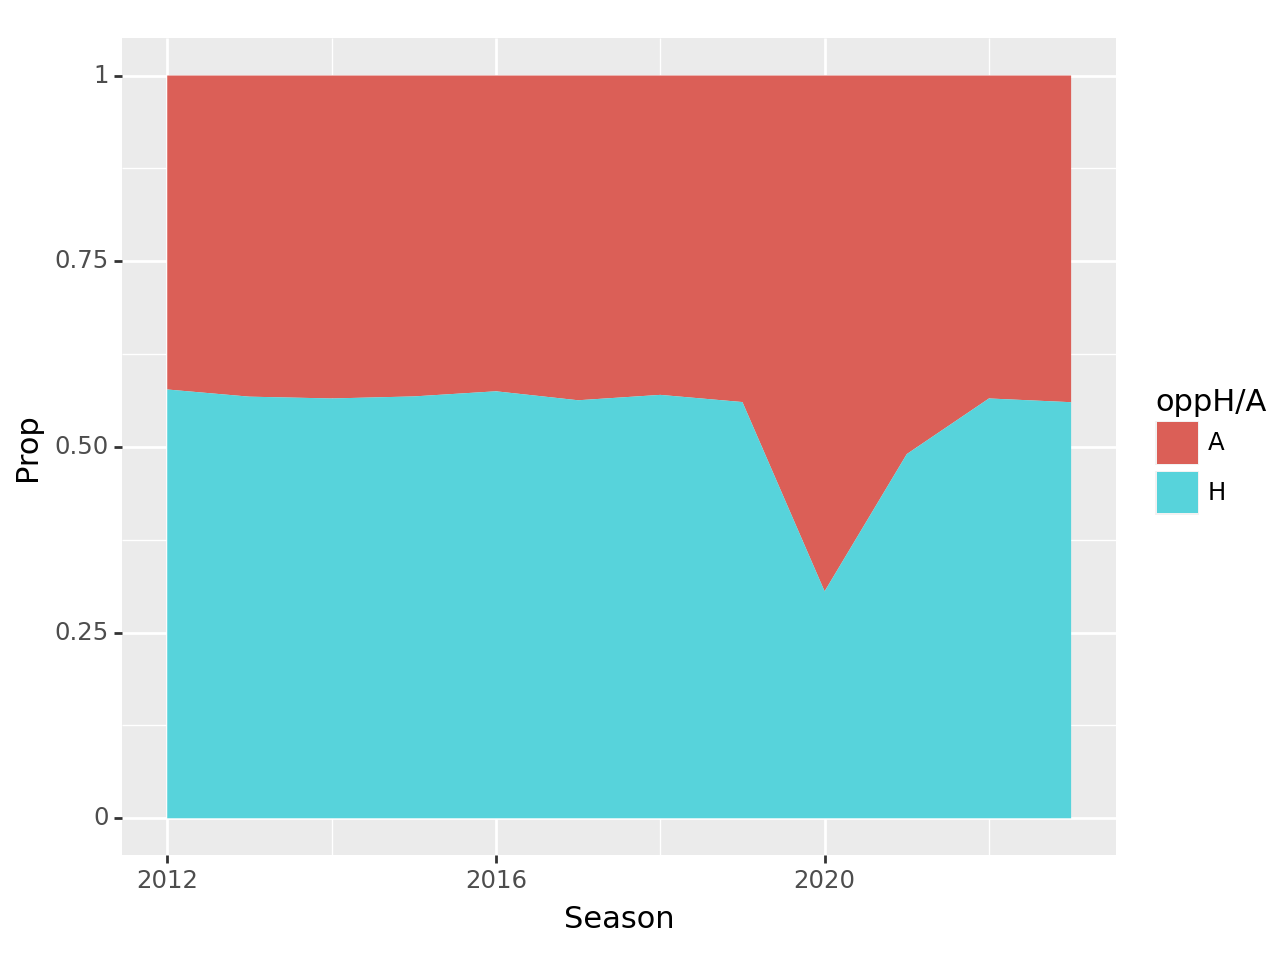

In [53]:
for var in cat_vars:
    df_season_counts = df_cats.groupby(['Season',var]).agg('count').groupby('Season').sum()['Date']
    df_areas = df_cats.groupby(['Season',var]).agg('count').reset_index().merge(df_season_counts,on='Season',how='left')\
        [['Season',var,'Date_x','Date_y']]
    
    df_areas['Prop'] = df_areas['Date_x']/df_areas['Date_y']
    
    #Find any Season where data is missing and insert this row (with prop 0)
    #get unique value of the variable
    var_set = set(list(df_areas[var].unique()))
    season_list = list(df_areas['Season'].unique())
    for seas in season_list:
        #Get the variables that appear for that season
        seas_set = set(list(df_areas[df_areas['Season']==seas][var].unique()))
        #Find the ones not appearing in the season
        miss_list = list(var_set - seas_set)
        df_miss = pd.DataFrame({'Season':[seas for i in range(len(miss_list))],
                                var:miss_list,'Prop':[0.0 for i in range(len(miss_list))]})
        #Add to the aggregate dataframe
        df_areas = pd.concat([df_areas,df_miss],ignore_index=True)

    print(
        ggplot(df_areas, aes(x='Season',y='Prop',fill=var))
        + geom_area()
    )

### Summary:

 - **Teams**: Stable over time. No notable changes to number of teams.
 - **Venue**: Majority of games played in VIC until COVID-19, where more games moved to other states.
 - **Day**: Most games played on Sat, then Sun, then Fri. Week days more frequent in the covid period.
 - **H/A**: Slight majority of home games (likely due to shared stadiums). Away games more prominent in COVID likely due to VIC shutdown.